In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
import warnings
import os
warnings.filterwarnings("ignore")

In [ ]:
try:
    import rpy2.robjects as ro
    from rpy2.robjects.conversion import localconverter
    from rpy2.robjects import default_converter, numpy2ri
    from rpy2.rinterface_lib.embedded import RRuntimeError

    # 加载 R 库
    ro.r('library(CompQuadForm)')

    # 定义 R 函数字符串
    R_UNROOT_FUNC_STRING = """
    get_quantile <- function(Lambda1, alpha) {
        # 定义一个内部函数来寻找根
        fun1 <- function(x) { davies(x, Lambda1)$Qq - alpha }
        
        # 使用 tryCatch 来处理 uniroot 可能发生的错误
        result <- tryCatch({
            # uniroot 在一个指定的区间内寻找函数的根 (即函数值为0的点)
            uniroot(fun1, c(1e-9, 100000))$root
        }, error = function(e) {
            # 如果 uniroot 失败 (例如，在区间内没有找到根)，则返回 NA
            # 这比让整个程序崩溃要好得多
            return(NA_real_)
        })
        
        return(result)
    }
    """
    
    # 步骤 1: 在 R 的全局环境中执行函数的定义
    ro.r(R_UNROOT_FUNC_STRING)
    
    # 步骤 2: 从 R 的全局环境中获取这个函数对象
    r_get_quantile = ro.globalenv['get_quantile']
    
    RPY2_AVAILABLE = True
    print("rpy2 setup and R function definition successful.")
    print("Successfully fetched 'get_quantile' function from R environment.")


except ImportError:
    print("="*60); print("CRITICAL: rpy2 is not installed. Please run 'pip install rpy2'."); print("="*60)
    RPY2_AVAILABLE = False
    r_get_quantile = None # 确保在失败时变量存在
except RuntimeError as e:
    print("="*60); print("CRITICAL: An R runtime error occurred during setup."); print(f"Error: {e}")
    print("\nPlease check if R is installed and 'CompQuadForm' is installed in R."); print("="*60)
    RPY2_AVAILABLE = False
    r_get_quantile = None # 确保在失败时变量存在
except Exception as e:
    print("="*60); print("CRITICAL: An unexpected error occurred during rpy2 setup."); print(f"Error: {e}"); print("="*60)
    RPY2_AVAILABLE = False
    r_get_quantile = None # 确保在失败时变量存在



# =============================================================================
#
# Part 1: DRMV 算法核心 (DRMV Solver)
#
# =============================================================================
def _calculate_l0_eigenvalues(monthly_returns: pd.DataFrame, monthly_rho: float):
    # This function remains unchanged
    S1_np = monthly_returns.values; n, d = S1_np.shape
    s1_average = np.mean(S1_np, axis=0).reshape(d, 1)
    Acov = S1_np.T @ S1_np / n
    try: Acov_inv = np.linalg.inv(Acov)
    except np.linalg.LinAlgError: return None, None, None, None, None
    one_vec = np.ones((d, 1)); QR1 = (one_vec.T @ Acov_inv @ s1_average)[0, 0]; QR2 = (one_vec.T @ Acov_inv @ one_vec)[0, 0]; QR3 = (s1_average.T @ Acov_inv @ s1_average)[0, 0]
    QR_matrix = np.array([[QR3, QR1], [QR1, QR2]]); Mb_vector = np.array([[monthly_rho], [1]])
    try: lambda_c = np.linalg.inv(QR_matrix) @ Mb_vector
    except np.linalg.LinAlgError: return None, None, None, None, None
    lambda_1, lambda_2 = lambda_c[0, 0], lambda_c[1, 0]
    hat_phi = lambda_1 * (Acov_inv @ s1_average) + lambda_2 * (Acov_inv @ one_vec)
    CovZ0 = np.cov(S1_np.T); vec_RR_T_samples = np.einsum('ni,nj->nij', S1_np, S1_np).reshape(n, d * d)
    CovS_flat = np.cov(vec_RR_T_samples.T); CovS_tensor = CovS_flat.reshape(d, d, d, d)
    phi_outer = hat_phi @ hat_phi.T; CovYphi = np.einsum('lm,kjlm->kj', phi_outer, CovS_tensor)
    transform_matrix = np.eye(d) - one_vec @ hat_phi.T
    if abs(lambda_1) < 1e-9: return None, None, None, None, None
    CovZ1 = (transform_matrix @ CovYphi @ transform_matrix.T) / (lambda_1 ** 2)
    CovZ = CovZ0 + CovZ1; L0_eigenvalues = np.linalg.eig(CovZ)[0].real
    return L0_eigenvalues, s1_average, Acov, hat_phi, n

def _calculate_delta_rpy2(L0_eigenvalues: np.ndarray, monthly_returns: pd.DataFrame, s1_average: np.ndarray, confidence_level=0.95):
    """
    [REVISED] Uses the modern localconverter context manager for safe R calls.
    """
    n = monthly_returns.shape[0]
    try:
        sample_cov_inv = np.linalg.inv(np.cov(monthly_returns.values.T))
    except np.linalg.LinAlgError: return None
    mu_Sigma_inv_mu = s1_average.T @ sample_cov_inv @ s1_average
    parad = 4 * (1 - mu_Sigma_inv_mu[0,0])
    if parad <= 1e-6: return None
    
    alpha = 1.0 - confidence_level
    clipped_eigenvalues = np.clip(L0_eigenvalues, a_min=None, a_max=500)
    
    L0_quantile = None
    # 使用 localconverter 来创建临时的、安全的转换上下文
    with localconverter(default_converter + numpy2ri.converter) as cv:
        r_result = r_get_quantile(clipped_eigenvalues, alpha)
        # 检查 R 是否返回了 NA (失败标志)
        if r_result[0] is not ro.NA_Real:
            L0_quantile = r_result[0]

    if L0_quantile is None:
        return None
        
    delta = L0_quantile / n / parad
    return delta

def _solve_robust_portfolio(monthly_returns: pd.DataFrame, monthly_rho: float, delta: float, Acov: np.ndarray, s1_average: np.ndarray, Mphi: np.ndarray, confidence_level=0.95):
    # This function remains unchanged
    n, d = monthly_returns.shape; p_norm = 2
    Evar = np.sqrt(max(0, Mphi.T @ np.cov(monthly_returns.values.T) @ Mphi))[0,0]
    epsilon = 1.0 - confidence_level; lel = norm.ppf(epsilon)
    denominator = np.sqrt(n) * np.linalg.norm(Mphi, ord=p_norm) * np.sqrt(delta)
    if denominator < 1e-9: v0 = 1.0
    else: v0 = 1 - (lel * Evar) / denominator
    v0 = max(v0, 0)
    alpha_bar = monthly_rho - np.linalg.norm(Mphi, ord=p_norm) * np.sqrt(delta) * v0
    def objective_func(phi):
        phi = phi.reshape(d, 1); var_term = phi.T @ Acov @ phi - (phi.T @ s1_average)**2
        risk_term = np.sqrt(max(var_term, 0))
        regularization_term = np.sqrt(delta) * np.linalg.norm(phi, ord=p_norm)
        return risk_term + regularization_term
    def nonlinear_constraint_func(phi):
        phi = phi.reshape(d, 1)
        constraint_value = (phi.T @ s1_average) - np.sqrt(delta) * np.linalg.norm(phi, ord=p_norm) - alpha_bar
        return constraint_value[0,0]
    x0 = np.ones(d) / d; bounds = tuple((0, 1) for _ in range(d))
    eq_cons = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}; nlin_cons = {'type': 'ineq', 'fun': nonlinear_constraint_func}
    constraints = [eq_cons, nlin_cons]
    result = minimize(fun=objective_func, x0=x0, method='SLSQP', bounds=bounds, constraints=constraints, options={'disp': False, 'ftol': 1e-9})
    return result.x if result.success else np.ones(d) / d

def get_drmv_weights(monthly_returns_df: pd.DataFrame, annual_target_return: float):
    # This function remains unchanged
    monthly_rho = (1 + annual_target_return)**(1/12) - 1; d = monthly_returns_df.shape[1]
    l0_eig, mu_n, E_rr, phi_n, n_samples = _calculate_l0_eigenvalues(monthly_returns_df, monthly_rho)
    if l0_eig is None: return np.ones(d) / d
    delta = _calculate_delta_rpy2(l0_eig, monthly_returns_df, mu_n)
    if delta is None or delta < 0: return np.ones(d) / d
    weights = _solve_robust_portfolio(monthly_returns_df, monthly_rho, delta, E_rr, mu_n, phi_n)
    return weights

# =============================================================================
#
# Part 2 & 3: Backtesting Engine & Main Runner
# (These parts remain unchanged from the previous correct version)
#
# =============================================================================
def run_single_backtest(
    all_data_df: pd.DataFrame, 
    n_stocks: int,
    transaction_cost: float,
    annual_target_return: float,
    backtest_start_date: str,
    backtest_end_date: str, 
    all_seed: int = 42, r=0.02
):
    rebalancing_dates = pd.date_range(start=backtest_start_date, end=backtest_end_date, freq='MS')
    wealth = 1.0
    current_weights = np.array([])
    current_perms = []
    wealth_history = {rebalancing_dates[0] - pd.DateOffset(days=1): wealth}

    for num, i in enumerate(range(len(rebalancing_dates))):
        rebal_date = rebalancing_dates[i]
        
        if i > 0:
            prev_rebal_date = rebalancing_dates[i-1]
            if len(current_perms) > 0:
                oos_data = all_data_df[(all_data_df['permno'].isin(current_perms)) & (all_data_df['date'] >= prev_rebal_date) & (all_data_df['date'] < rebal_date)]
                monthly_returns_oos = oos_data.pivot_table(index='date', columns='permno', values='ret').resample('M').apply(lambda x: (1 + x).prod() - 1)
                monthly_returns_oos[0] = (1 + r)**(1/12) - 1  #risk free add
                if monthly_returns_oos.empty:
                    portfolio_return = 0
                else:
                    actual_returns_series = monthly_returns_oos.iloc[0].reindex(current_perms)
                    actual_returns = np.nan_to_num(actual_returns_series.values, nan=-1.0)
                    portfolio_return = np.dot(current_weights, actual_returns)
            else:
                portfolio_return = 0
            wealth *= (1 + portfolio_return)
            if portfolio_return != -1 and len(current_perms) > 0:
                 weights_after_return = current_weights * (1 + actual_returns) / (1 + portfolio_return)
            else:
                 weights_after_return = np.zeros_like(current_weights)
        else:
            weights_after_return = np.array([])
        
        training_start_date = rebal_date - relativedelta(years=10)
        future_date = rebal_date + relativedelta(months=1)
        active_stocks = all_data_df[(all_data_df['start'] <= rebal_date) & (all_data_df['ending'] >= future_date)]
        eligible_stocks = []
        for permno in active_stocks['permno'].unique():
            if all_data_df[all_data_df['permno'] == permno]['date'].min() <= training_start_date:
                eligible_stocks.append(permno)
        
        if len(eligible_stocks) < n_stocks:
            new_weights = np.array([])
            selected_perms = []
        else:
            np.random.seed(all_seed*1000+num)  # Ensure reproducibility
            selected_perms = np.random.choice(eligible_stocks, n_stocks, replace=False)
            training_data = all_data_df[(all_data_df['permno'].isin(selected_perms)) & (all_data_df['date'] >= training_start_date) & (all_data_df['date'] < rebal_date)]
            monthly_returns_train = training_data.pivot_table(index='date', columns='permno', values='ret').resample('M').apply(lambda x: (1 + x).prod() - 1).dropna()
            monthly_returns_train[0] = (1 + r)**(1/12) - 1 + np.random.normal(0, 0.005, len(monthly_returns_train))  #risk free add
            # add risk free permno 0 to selected_perms
            selected_perms = np.append(selected_perms, 0)
            if monthly_returns_train.shape[0] < 118:
                new_weights = np.ones(n_stocks+1) / (n_stocks+1)
            else:
                monthly_returns_train = monthly_returns_train[selected_perms]
                new_weights = get_drmv_weights(monthly_returns_train, annual_target_return)
                print(new_weights)

        old_holdings = pd.Series(weights_after_return, index=current_perms, name='old').fillna(0)
        new_target = pd.Series(new_weights, index=selected_perms, name='new').fillna(0)
        combined_df = pd.concat([old_holdings, new_target], axis=1).fillna(0)
        turnover = np.sum(np.abs(combined_df['new'] - combined_df['old']))
        cost = wealth * turnover * transaction_cost
        wealth -= cost
        
        wealth_history[rebal_date] = wealth
        current_weights = new_weights
        current_perms = selected_perms
        
    return pd.Series(wealth_history, name='Wealth')

    

sh: which: line 1: syntax error: unexpected end of file
sh: error importing function definition for `which'
sh: module: line 1: syntax error: unexpected end of file
sh: error importing function definition for `module'
sh: _module_raw: line 1: syntax error: unexpected end of file
sh: error importing function definition for `_module_raw'
sh: switchml: line 1: syntax error: unexpected end of file
sh: error importing function definition for `switchml'
sh: which: line 1: syntax error: unexpected end of file
sh: error importing function definition for `which'
sh: module: line 1: syntax error: unexpected end of file
sh: error importing function definition for `module'
sh: _module_raw: line 1: syntax error: unexpected end of file
sh: error importing function definition for `_module_raw'
sh: switchml: line 1: syntax error: unexpected end of file
sh: error importing function definition for `switchml'


rpy2 setup and R function definition successful.
Successfully fetched 'get_quantile' function from R environment.


In [ ]:
def run_single_backtest_select_stocks(
    training_data: pd.DataFrame,
    selected_perms: np.ndarray,
    annual_target_return: float,
    r: float,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Calculate DRMV weights for a single rebalancing period.
    """
    # Resample to monthly returns from daily data
    monthly_returns_train = training_data.pivot_table(
        index='date', columns='permno', values='ret'
    ).resample('M').apply(lambda x: (1 + x).prod() - 1).dropna()
    
    # Add risk-free asset
    risk_free_returns = (1 + r)**(1/12) - 1 + np.random.normal(0, 0.0003, len(monthly_returns_train))
    monthly_returns_train[0] = risk_free_returns
    
    perms_with_rf = np.append(selected_perms, 0)
    
    # Ensure columns are in the correct order
    monthly_returns_train = monthly_returns_train.reindex(columns=perms_with_rf)

    # Check for sufficient training data
    if monthly_returns_train.shape[0] < 118:
        # Return equal weights if not enough data
        new_weights = np.ones(len(selected_perms) + 1) / (len(selected_perms) + 1)
    else:
        new_weights = get_drmv_weights(monthly_returns_train, annual_target_return)
        
    return new_weights


In [23]:
np.random.normal(0, 0.01, 4)

array([-0.00931903, -0.0012504 ,  0.00524099, -0.01477185])

In [7]:
N_EXPERIMENTS = 1; N_STOCKS = 5; TRANSACTION_COST = 0
ANNUAL_TARGET_RETURN = 0.105; BACKTEST_START = '2007-07-01'
BACKTEST_END = '2008-07-01'; DATA_FILE = 'sp500_data.csv.gz'

try:
    print(f"Loading data from {DATA_FILE}..."); df = pd.read_csv(DATA_FILE)
    for col in ['date', 'start', 'ending']: df[col] = pd.to_datetime(df[col], errors='coerce')
    df.dropna(subset=['date', 'start', 'ending', 'permno', 'ret'], inplace=True)
    print("Data loaded and preprocessed successfully.")
except FileNotFoundError: print(f"Error: Data file '{DATA_FILE}' not found."); exit()

all_wealth_curves = []
print(f"\nStarting {N_EXPERIMENTS} backtesting experiments...")
for i in tqdm(range(N_EXPERIMENTS), desc="Running Experiments"):
    np.random.seed(i)
    wealth_series = run_single_backtest(
        all_data_df=df, n_stocks=N_STOCKS, transaction_cost=TRANSACTION_COST,
        annual_target_return=ANNUAL_TARGET_RETURN, backtest_start_date=BACKTEST_START,
        backtest_end_date=BACKTEST_END, all_seed=97
    )
    all_wealth_curves.append(wealth_series)

print("All experiments completed.")

if not all_wealth_curves: print("No wealth curves were generated.")
else:
    results_df = pd.concat(all_wealth_curves, axis=1)
    average_wealth = results_df.mean(axis=1)
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 8))
    for col in results_df.columns: ax.plot(results_df.index, results_df[col], color='gray', alpha=0.1)
    ax.plot(average_wealth.index, average_wealth, color='navy', linewidth=2.5, label=f'Average Wealth ({N_EXPERIMENTS} runs)')
    ax.set_title(f'DRMV Portfolio Backtest ({N_STOCKS} Stocks)', fontsize=16)
    ax.set_xlabel('Date', fontsize=12); ax.set_ylabel('Wealth (Log Scale)', fontsize=12)
    ax.set_yscale('log'); ax.legend(fontsize=12); ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    from matplotlib.ticker import FuncFormatter
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2f}'))
    plt.tight_layout(); plt.show()

Loading data from sp500_data.csv.gz...


Data loaded and preprocessed successfully.

Starting 1 backtesting experiments...


Running Experiments:   0%|          | 0/1 [00:00<?, ?it/s]

[0.07384284 0.0617479  0.06279993 0.11412251 0.1808305  0.50665632]
[0.04661298 0.06838307 0.04244189 0.11392316 0.0407012  0.6879377 ]
[0.13711076 0.1248593  0.03299036 0.05972717 0.02018248 0.62512993]
[0.09503971 0.09923309 0.12909403 0.15356077 0.05477066 0.46830173]


Running Experiments:   0%|          | 0/1 [08:51<?, ?it/s]


KeyboardInterrupt: 

In [2]:
import os

# get all filenames in /res
res_dir = 'res/'
files = os.listdir(res_dir)
files = [file for file in files if '1524' in file and 'riskfree' in file]
for num, file in enumerate(files):
    if num==0:
        file_path = os.path.join(res_dir, file)
        df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    else:
        file_path = os.path.join(res_dir, file)
        df2 = pd.read_csv(file_path, index_col=0, parse_dates=True)
        df = pd.concat([df, df2], axis=1, ignore_index=True)
df


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2014-12-31,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2015-01-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2015-02-01,0.992617,1.004279,0.983970,0.990668,0.983142,0.971733,0.988121,1.006024,1.002325,1.001454,...,0.985684,1.004910,0.996811,1.006230,1.005956,0.993889,0.991936,0.998895,1.010021,1.006986
2015-03-01,1.013673,1.018111,0.982464,1.000878,0.995238,0.976290,1.004991,1.015024,1.029925,1.003931,...,0.988811,1.027529,0.996081,1.023876,1.029899,1.015316,1.019130,1.009343,0.998921,0.998971
2015-04-01,0.976807,1.006754,0.977421,0.991667,0.995336,0.971540,1.006320,0.985172,1.026168,1.000676,...,0.987326,1.025697,0.993367,1.025178,1.024839,1.014425,1.019191,1.004897,0.997855,1.001246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,1.665816,1.698691,1.588736,1.552929,1.456137,1.579364,1.647716,1.479806,1.762240,1.651572,...,1.531693,1.746565,1.653299,1.467692,1.763852,1.191345,1.663989,1.450080,1.629141,1.785180
2024-09-01,1.710789,1.758663,1.604619,1.575085,1.499177,1.596705,1.660785,1.515877,1.797794,1.667772,...,1.557068,1.784706,1.672275,1.490754,1.790721,1.213312,1.694175,1.483279,1.650050,1.806060
2024-10-01,1.716459,1.765633,1.624352,1.599676,1.507055,1.607966,1.665998,1.532078,1.819494,1.673052,...,1.562099,1.799132,1.666371,1.496618,1.803787,1.219641,1.714753,1.497052,1.655561,1.830946
2024-11-01,1.701347,1.775307,1.610671,1.584959,1.499312,1.620282,1.685202,1.516943,1.812354,1.666818,...,1.554702,1.795001,1.645097,1.479789,1.826469,1.199621,1.709862,1.479835,1.641532,1.814455


<Axes: title={'center': 'Average Wealth Curve, risk free asset, n=20, 1524'}>

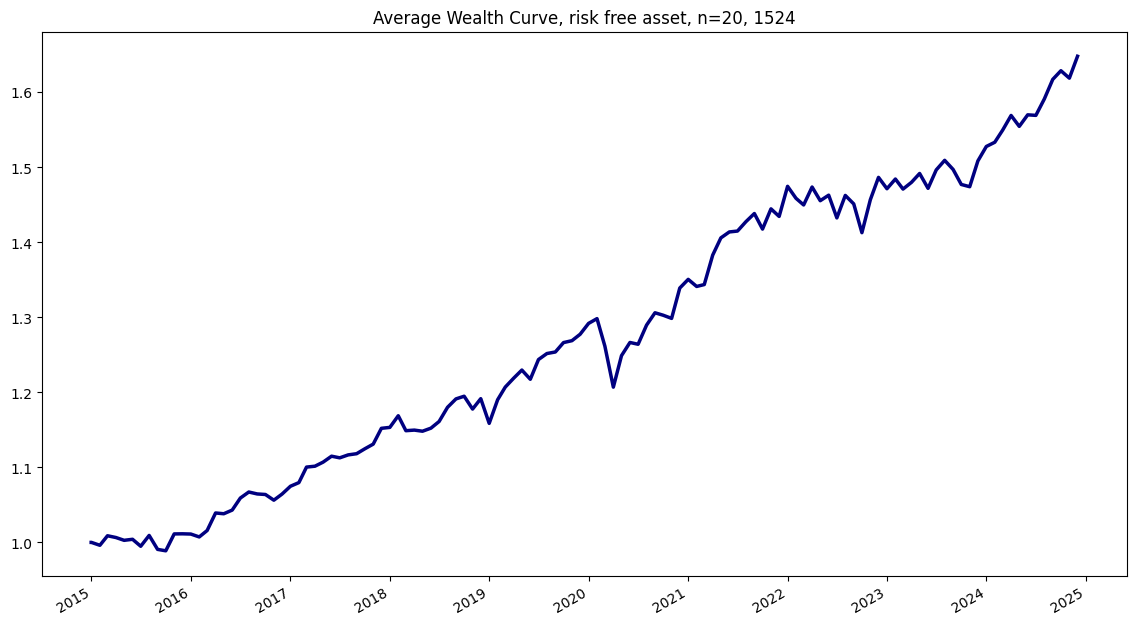

In [3]:
# average df columns
average_df = df.mean(axis=1)
average_df.plot(figsize=(14, 8), title='Average Wealth Curve, risk free asset, n=20, 1524', color='navy', linewidth=2.5)

<Axes: title={'center': 'Average Wealth Curve, no risk free asset, n=20'}>

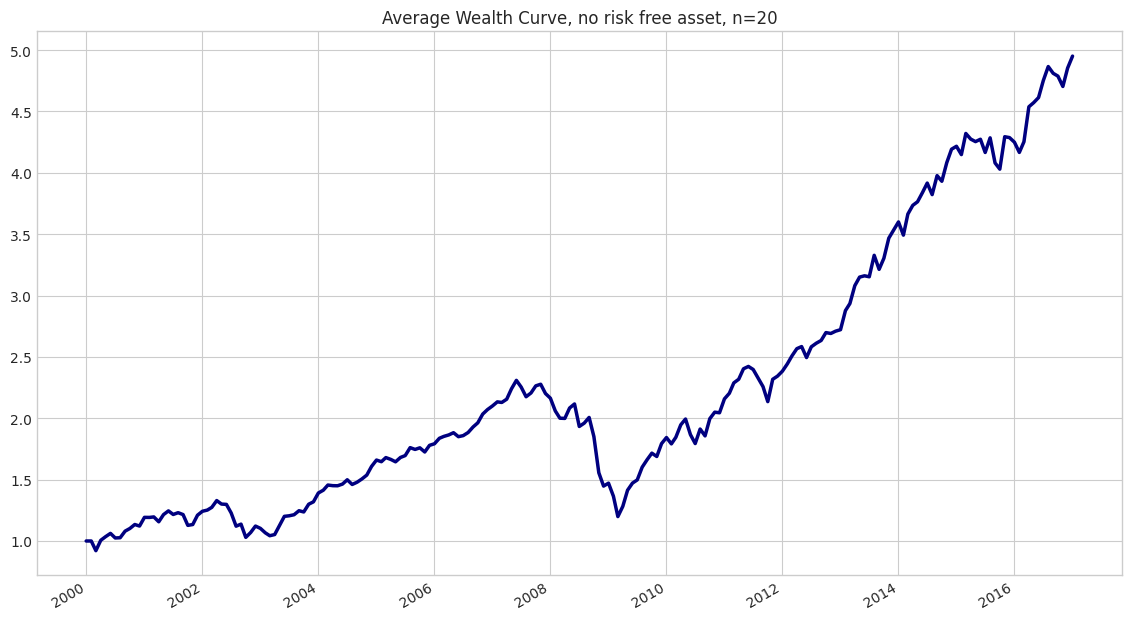

In [55]:
# average df columns
average_df = df.mean(axis=1)
average_df.plot(figsize=(14, 8), title='Average Wealth Curve, no risk free asset, n=20', color='navy', linewidth=2.5)

<Axes: title={'center': 'Average Wealth Curve, risk free asset, n=20, r=0.02'}>

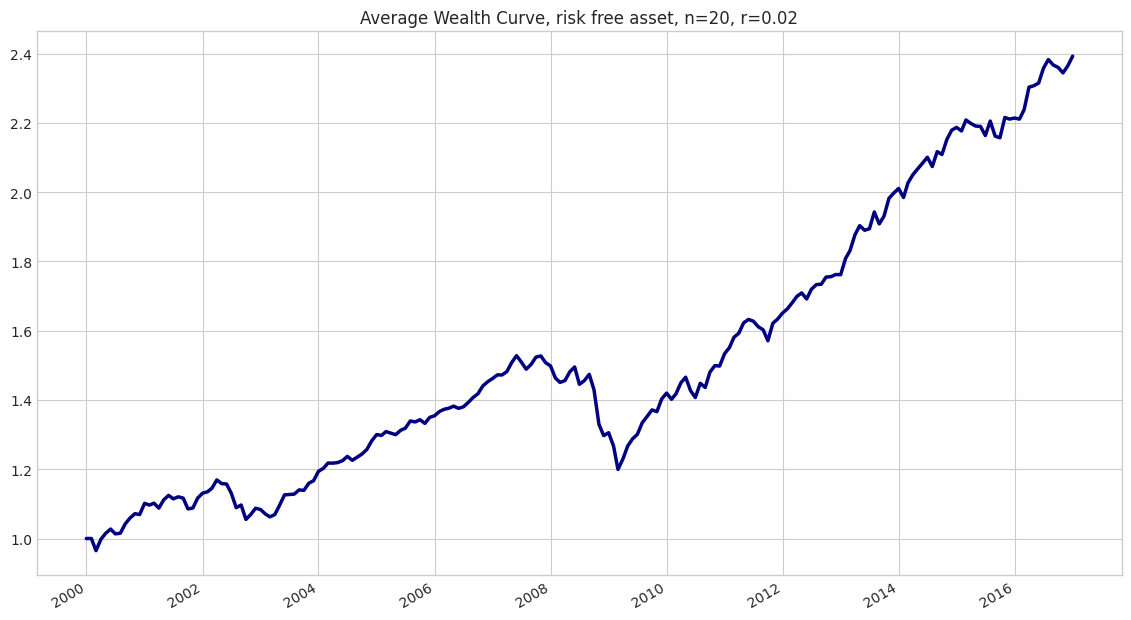

In [40]:
# average df columns
average_df = df.mean(axis=1)
average_df.plot(figsize=(14, 8), title='Average Wealth Curve, risk free asset, n=20, r=0.02', color='navy', linewidth=2.5)

<Axes: title={'center': 'Average Wealth Curve'}>

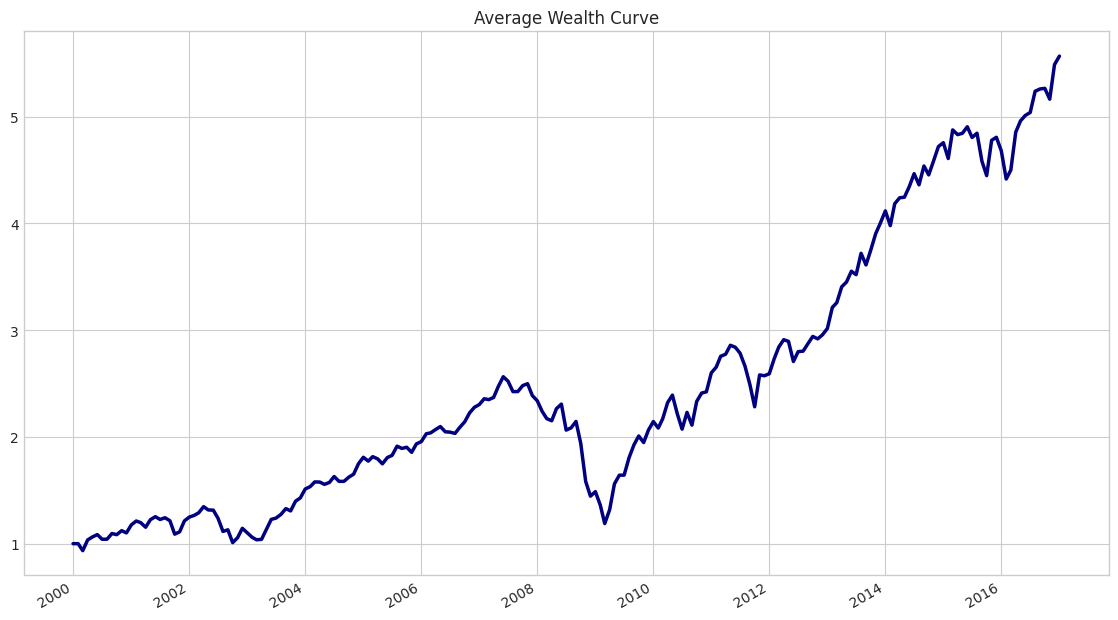

In [32]:
# average df columns
average_df = df.mean(axis=1)
average_df.plot(figsize=(14, 8), title='Average Wealth Curve', color='navy', linewidth=2.5)

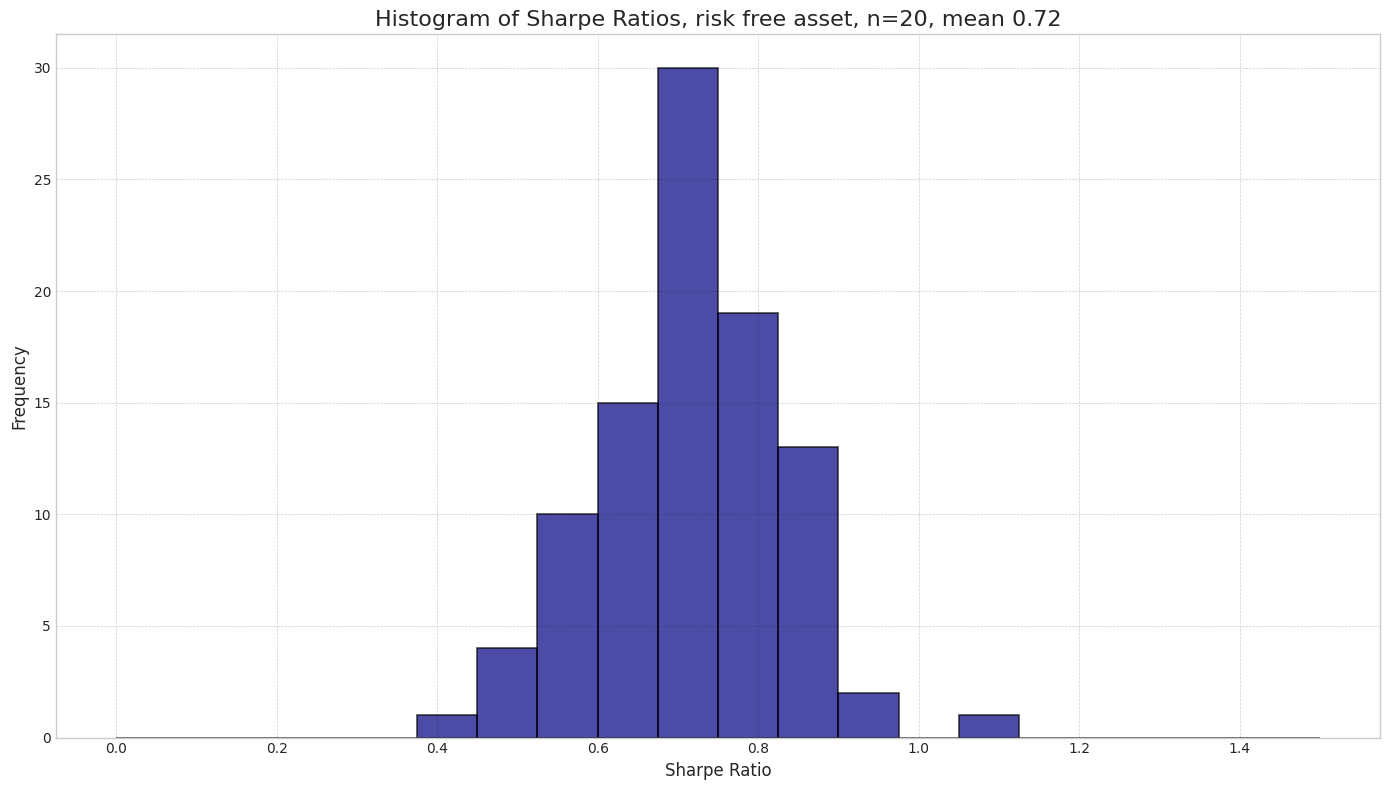

In [56]:
# calculate sharpe ratio for each column, now df is total wealth curve
returns = df.pct_change()
sharpe_ratios = returns.mean() / returns.std() * np.sqrt(12)
# plot histogram of sharpe ratios, x range from 0 to 1.5, 15 bins, color navy, make bars separate
plt.figure(figsize=(14, 8))
sharpe_ratios.plot(kind='hist', bins=20, range=(0, 1.5), color='navy', alpha=0.7, edgecolor='black', linewidth=1.2)
plt.title(f'Histogram of Sharpe Ratios, risk free asset, n=20, mean {sharpe_ratios.mean():.2f}', fontsize=16)
plt.xlabel('Sharpe Ratio', fontsize=12); plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5); plt.tight_layout(); plt.show()

In [51]:
sharpe_ratios.mean()

np.float64(0.8899575008124231)

In [70]:
df

,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
1999-12-31,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2000-01-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2000-02-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2000-03-01,0.947074,0.970477,0.970395,0.965921,0.949935,0.958744,0.973765,0.971351,0.980510,0.963765,...,0.969037,0.956845,0.947330,0.970957,0.971594,0.942881,0.976351,0.957491,0.955312,0.962619
2000-04-01,0.976346,0.987989,0.995682,1.021111,0.983537,0.991911,1.023078,1.010129,1.033401,0.983894,...,1.003757,0.974303,1.006981,1.005757,1.015811,0.976574,1.033365,0.979787,0.993564,1.009826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-09-01,2.488535,1.868206,1.824641,1.975427,1.500090,1.905440,2.450288,2.273047,2.830970,2.692131,...,2.258562,2.293803,2.122022,2.266168,2.820368,2.157266,2.506075,2.645983,2.909152,2.113352
2016-10-01,2.489375,1.876798,1.818408,1.974746,1.499644,1.886318,2.413604,2.251063,2.831586,2.699805,...,2.259493,2.298687,2.114982,2.245890,2.809508,2.157327,2.496612,2.622634,2.873568,2.114911
2016-11-01,2.475766,1.839086,1.809039,1.964106,1.494196,1.847676,2.412583,2.224073,2.811410,2.666910,...,2.234057,2.281837,2.092586,2.282266,2.766950,2.157209,2.518115,2.579426,2.898147,2.074377
2016-12-01,2.515080,1.850243,1.835187,1.969479,1.490880,1.856144,2.419496,2.235310,2.950086,2.668714,...,2.258157,2.249349,2.104609,2.290887,2.752034,2.196805,2.540637,2.609433,2.919658,2.114434


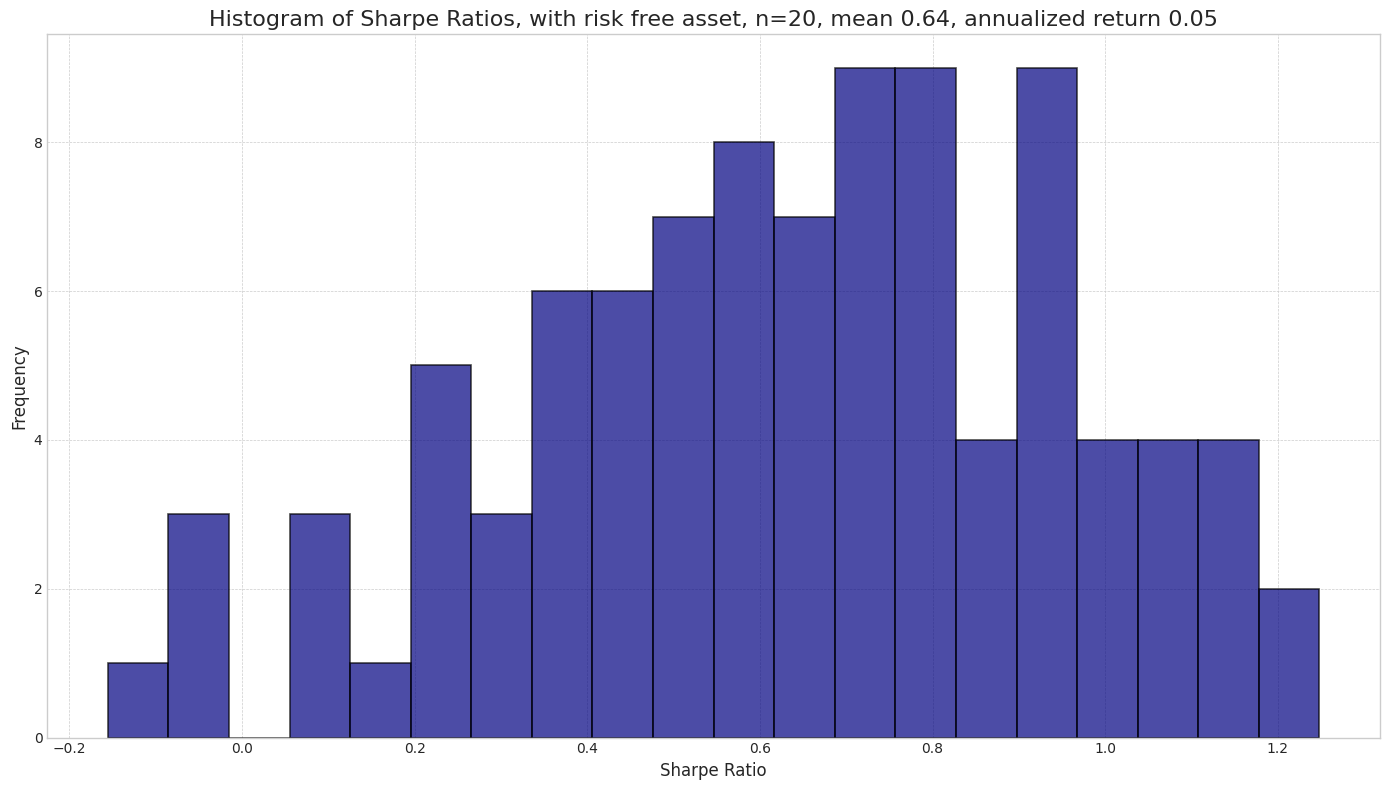

In [68]:
# calculate sharpe ratio for each column, now df is total wealth curve
returns = df.pct_change()
sharpe_ratios = returns.loc[returns.index[-1]] / returns.loc[returns.index[-1]].std() / np.sqrt(10)
# plot histogram of sharpe ratios, x range from 0 to 1.5, 15 bins, color navy, make bars separate
plt.figure(figsize=(14, 8))
sharpe_ratios.plot(kind='hist', bins=20, color='navy', alpha=0.7, edgecolor='black', linewidth=1.2)
plt.title(f'Histogram of Sharpe Ratios, with risk free asset, n=20, mean {sharpe_ratios.mean():.2f}, annualized return {returns.mean().mean()*12:.2f}', fontsize=16)
plt.xlabel('Sharpe Ratio', fontsize=12); plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5); plt.tight_layout(); plt.show()

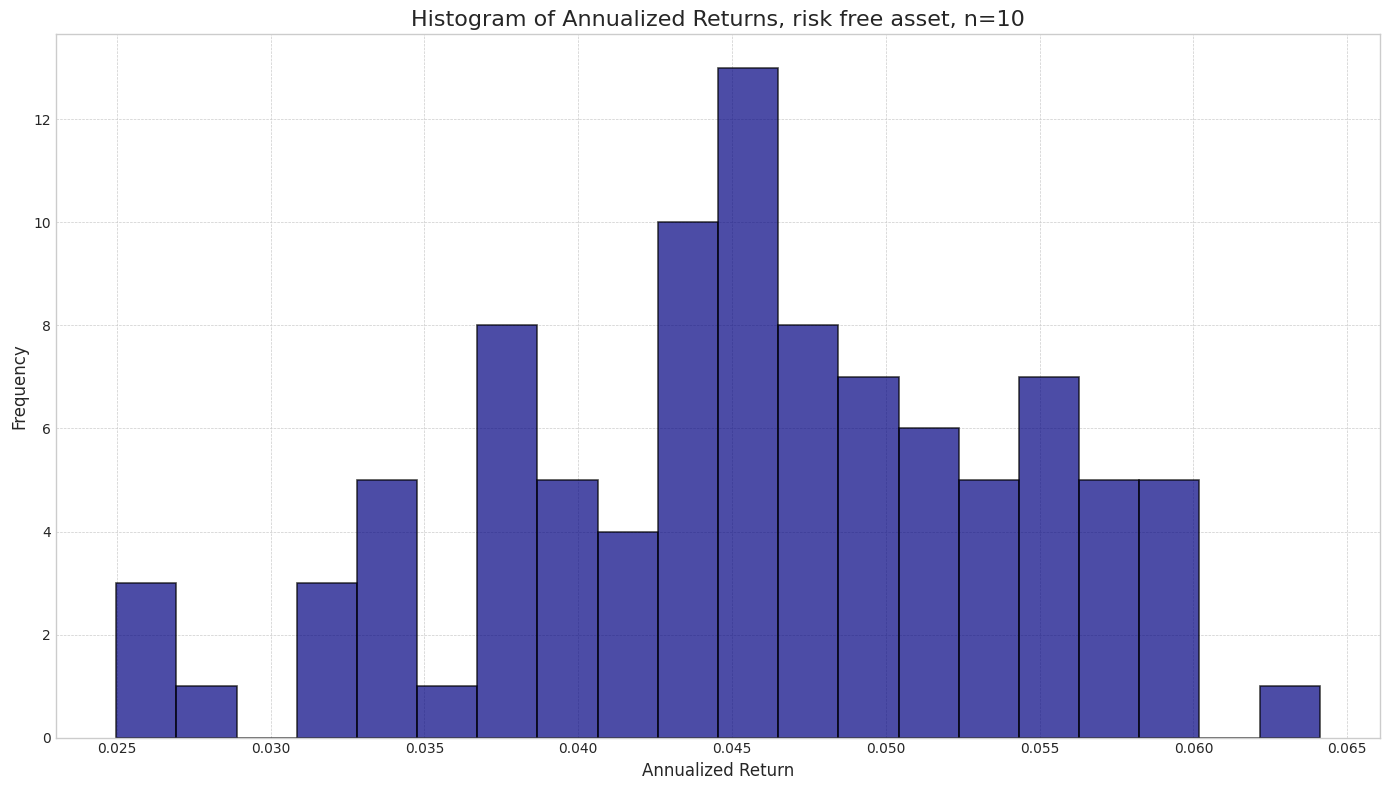

In [45]:
# calculate annualized return for each column
annualized_returns = df.apply(lambda x: (x.iloc[-1] / x.iloc[0]) ** (1 / (len(x) / 12)) - 1)
# plot histogram of annualized returns, x range from 0.08 to 0.12, 15 bins, color navy, make bars separate
plt.figure(figsize=(14, 8))
annualized_returns.plot(kind='hist', bins=20, color='navy', alpha=0.7, edgecolor='black', linewidth=1.2)
plt.title('Histogram of Annualized Returns, risk free asset, n=10', fontsize=16)
plt.xlabel('Annualized Return', fontsize=12); plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5); plt.tight_layout(); plt.show()

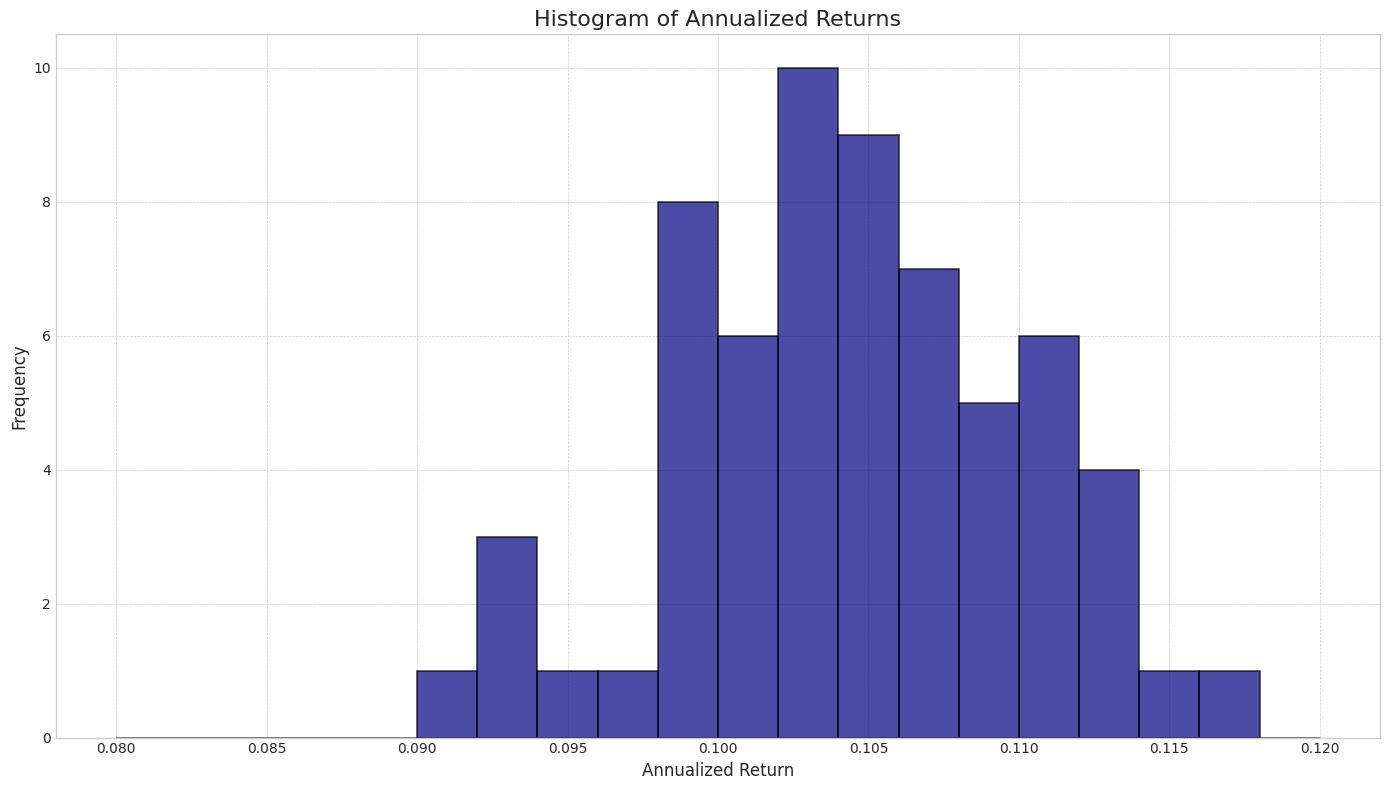

In [29]:
# calculate annualized return for each column
annualized_returns = df.apply(lambda x: (x.iloc[-1] / x.iloc[0]) ** (1 / (len(x) / 12)) - 1)
# plot histogram of annualized returns, x range from 0.08 to 0.12, 15 bins, color navy, make bars separate
plt.figure(figsize=(14, 8))
annualized_returns.plot(kind='hist', bins=20, range=(0.08, 0.12), color='navy', alpha=0.7, edgecolor='black', linewidth=1.2)
plt.title('Histogram of Annualized Returns', fontsize=16)
plt.xlabel('Annualized Return', fontsize=12); plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5); plt.tight_layout(); plt.show()

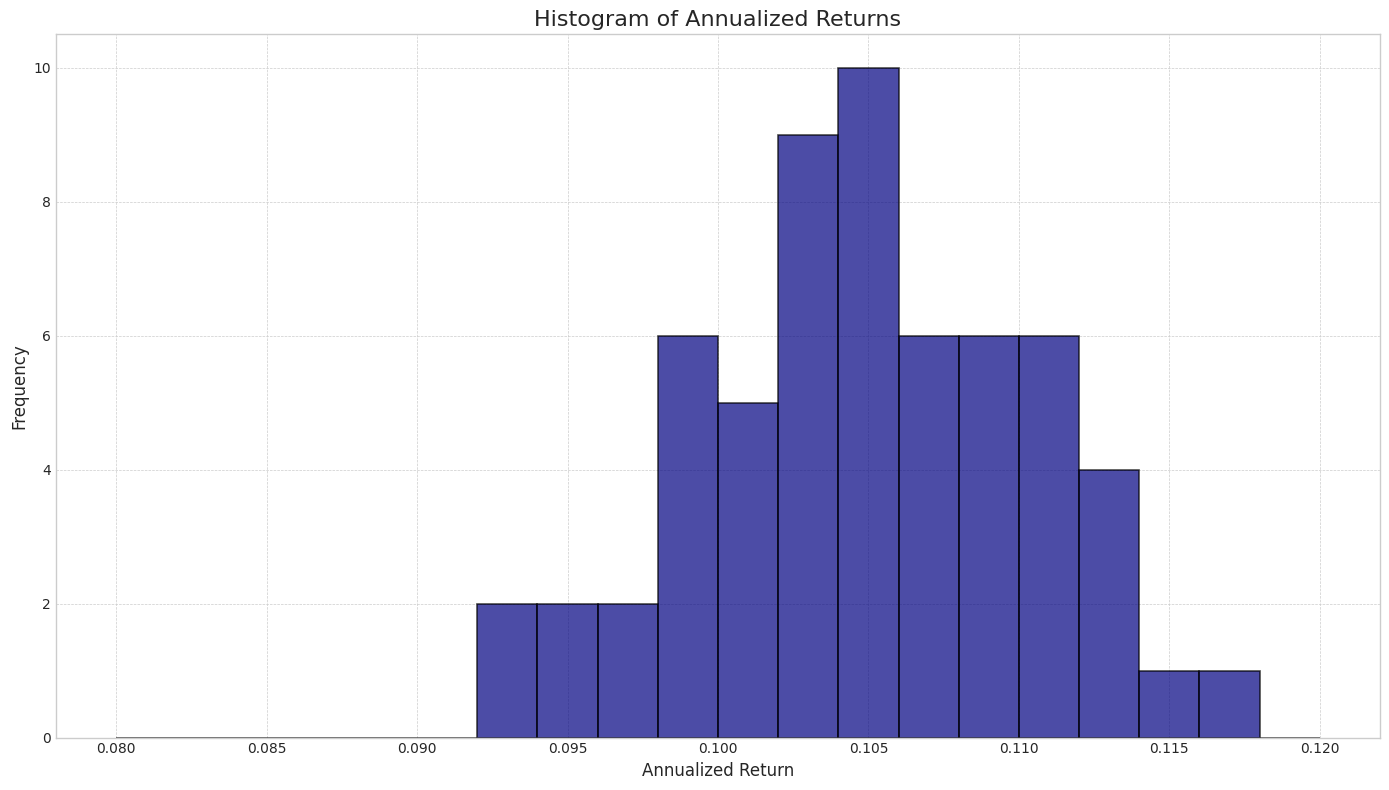

In [33]:
# calculate annualized return for each column
annualized_returns = df.apply(lambda x: (x.iloc[-1] / x.iloc[0]) ** (1 / (len(x) / 12)) - 1)
# plot histogram of annualized returns, x range from 0.08 to 0.12, 15 bins, color navy, make bars separate
plt.figure(figsize=(14, 8))
annualized_returns.plot(kind='hist', bins=20, range=(0.08, 0.12), color='navy', alpha=0.7, edgecolor='black', linewidth=1.2)
plt.title('Histogram of Annualized Returns', fontsize=16)
plt.xlabel('Annualized Return', fontsize=12); plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5); plt.tight_layout(); plt.show()

In [2]:
def set_hyperparams(dim=2, sigma=None):
    adjustment = 1

    # Parameters
    r = 0.06          # Risk-free rate
    if sigma is None:
        sigma = 1 * np.eye(dim)  # Adjusted volatility
    sigma = adjustment * sigma
    T = 1             # Time horizon
    x0 = 1            # Initial wealth
    B_values = np.tile(np.array([0.01, 0.46, 0.30, 0.21, 0.27]), (dim,1))  # Support of B (positive values only)
    B_probs = np.tile(np.array([0.5, 0.05, 0.2, 0.15, 0.1]), (dim,1))#[0.05, 0.35, 0.35, 0.15, 0.1]  # Probabilities for each value in B
    num_simulations = 10000  # Number of simulations
    dt = 0.001         # Time step
    alpha = 0.5       # Risk aversion parameter

    # Time discretization
    N = int(T / dt)   # Number of time steps
    t = np.linspace(0, T, N + 1)
    # pi_init = np.load('pi_t_list.npy', allow_pickle=True)
    
    # check if sigma is invertiable
    if np.linalg.matrix_rank(sigma) != dim:
        raise ValueError("Sigma is not invertible")
    
    return r, sigma, T, x0, B_values, B_probs, num_simulations, dt, alpha, N, t

r, sigma, T, x0, B_values, B_probs, num_simulations, dt, alpha, N, t = set_hyperparams(dim=3)

In [235]:
def L_t_vectorized(t, z, y, r, sigma):
    """
    计算高维向量化的 L_t(t, z, y)。

    这个函数可以处理z和y的多种输入情况:
    - z: 单个向量 (dim,) 或 多个向量 (n_samples, dim)
    - y: 单个向量 (dim,) 或 多个向量 (m_samples, dim)

    参数:
        t (float): 时间参数。
        z (ndarray): 形状为 (dim,) 或 (n_samples, dim) 的数组。
        y (ndarray): 形状为 (dim,) 或 (m_samples, dim) 的数组。
        r (float or ndarray): 无风险利率。可以是标量或形状为 (dim,) 的向量。
        sigma (ndarray): 协方差矩阵，形状为 (dim, dim)。

    返回:
        根据输入y和z的维度，返回一个标量或一个数组。
        - z(1,d), y(1,d) -> scalar
        - z(n,d), y(1,d) -> (n,)
        - z(1,d), y(m,d) -> (m,)
        - z(n,d), y(m,d) -> (n, m)
    """
    # 确保 y 和 z 至少是二维的，方便统一处理
    original_z_dim = np.ndim(z)
    original_y_dim = np.ndim(y)
    
    y = np.atleast_2d(y)  # 形状变为 (m_samples, dim)
    z = np.atleast_2d(z)  # 形状变为 (n_samples, dim)

    if t == 0.0:
        # L_t 在 t=0 时为 1
        # 我们需要根据 z 和 y 的样本数决定输出的形状
        n_samples = z.shape[0]
        m_samples = y.shape[0]
        # 创建一个 (n_samples, m_samples) 的矩阵
        # 如果原始输入是1D，最后会通过 squeeze() 降维
        ones = np.ones((n_samples, m_samples))
        if original_z_dim == 1 and original_y_dim == 1:
            return 1.0
        if original_z_dim > 1 and original_y_dim == 1:
            return ones[:, 0]
        if original_z_dim == 1 and original_y_dim > 1:
            return ones[0, :]
        return ones


    # 预计算 sigma 的逆
    sigma_inv = np.linalg.inv(sigma)
    
    # z - r，支持 r 是标量或向量
    diff = z - r  # 形状 (n_samples, dim)
    
    # A = (z - r) @ sigma_inv
    A = diff @ sigma_inv # 形状 (n_samples, dim)
    
    # standardize A
    #A = A / np.linalg.norm(A, axis=1, keepdims=True)  # 归一化每个样本的 A
    
    # 计算点积项: A @ y.T
    # A: (n_samples, dim), y.T: (dim, m_samples) -> dot_term: (n_samples, m_samples)
    dot_term = A @ y.T
    
    # 计算平方范数项 ||A||^2
    # A**2 是元素级平方，沿维度1求和得到每个样本的范数平方
    norm_sq = np.sum(A**2, axis=1) # 形状 (n_samples,)
    
    # 计算指数项
    # norm_sq[:, np.newaxis] 将 (n_samples,) 变形为 (n_samples, 1)
    # 这允许它与 (n_samples, m_samples) 的 dot_term 进行广播相减
    exponent = dot_term - 0.5 * t * norm_sq[:, np.newaxis]
    
    # For each column, keep values between the 2nd and 98th percentile
    if exponent.shape[0] > 1: # Percentiles are meaningful only for >1 sample
        p2 = np.percentile(exponent, 5, axis=0, keepdims=True)
        p98 = np.percentile(exponent, 95, axis=0, keepdims=True)
        
        # Create a mask for values within the percentile range
        mask = (exponent >= p2) & (exponent <= p98)
        
        # Replace values outside the range with -inf so they become 0 after exp()
        exponent = np.where(mask, exponent, -np.inf)

    result = np.exp(exponent)
    
    # 根据原始输入维度，调整输出形状，使其更符合直觉
    if original_z_dim == 1 and original_y_dim == 1:
        return result[0, 0] # 返回标量
    if original_z_dim > 1 and original_y_dim == 1:
        return result[:, 0] # 返回 (n_samples,) 数组
    if original_z_dim == 1 and original_y_dim > 1:
        return result[0, :] # 返回 (m_samples,) 数组
    
    return result # 返回 (n_samples, m_samples) 矩阵

In [236]:
def F_tilde_p_exact(t, y, joint_z_vectors, p_dist, r, sigma):
    """
    精确计算 F_tilde_p(t, y) = E_P[L_t(t, Z, y)]。

    参数:
        t (float): 时间参数。
        y (ndarray): 形状为 (dim,) 或 (n_y, dim) 的向量。
        joint_z_vectors (ndarray): 预先生成的m个n维向量，形状为 (m, dim)。
        p_dist (ndarray): 对应每个z向量的概率，形状为 (m,)。
        r, sigma: 模型参数。

    返回:
        F_tilde_p 的精确值。
    """
    # 1. 一次性计算所有m个z向量的L_t值。
    # L_t_vectorized 会返回一个形状为 (m,) 或 (m, n_y) 的数组。
    l_values = L_t_vectorized(t, joint_z_vectors, y, r, sigma)
    
    # make >99 percentile of l_values to 99 percentile of l_values
    l_values = np.where(l_values > np.percentile(l_values, 99), np.percentile(l_values, 99), l_values)

    # 2. 计算加权和（即期望）
    # 如果y是单个向量，l_values是(m,)，p_dist是(m,)，结果是标量。
    # 如果y是多个向量，l_values是(m, n_y)，p_dist是(m,)，
    # p_dist @ l_values (点积) 等价于 sum(p_i * l_i) for each y column
    # 结果是一个 (n_y,) 的数组。
    return p_dist @ l_values

def grad_F_tilde_p_exact(t, y, joint_z_vectors, p_dist, r, sigma):
    """
    精确计算 ∇_y F_tilde_p(t, y) = E_P[∇_y L_t(t, Z, y)]。
    """
    # 确保 y 至少是 2D
    original_y_dim = np.ndim(y)
    y = np.atleast_2d(y) # Shape (n_y, dim)
    dim = y.shape[1]
    
    # 1. 预计算所有 z 向量的梯度乘数 A(Z)
    sigma_inv = np.linalg.inv(sigma) # 假设sigma是波动率矩阵
    A = (joint_z_vectors - r) @ sigma_inv  # 形状 (m, dim)

    # 2. 计算 L_t 值
    l_values = L_t_vectorized(t, joint_z_vectors, y, r, sigma) # 形状 (m, n_y)
    
    # 3. 计算梯度的期望 E_P[L_t * A]
    # 我们需要为每个 y_j 计算 sum_i [p_dist[i] * l_values[i, j] * A[i, :]]
    # 这可以通过一个高效的矩阵乘法完成。
    # 首先，用概率对L值进行加权
    weighted_l_values = l_values * p_dist[:, np.newaxis] # 形状 (m, n_y)
    
    # 然后，计算加权后的L值与梯度乘数A的期望
    # weighted_l_values.T: (n_y, m) @ A: (m, dim) -> grad: (n_y, dim)
    grad = weighted_l_values.T @ A
    
    # 如果原始输入y是1D，则返回1D结果
    if original_y_dim == 1:
        return grad[0]
    return grad

In [237]:
def V_tilde_p_mixed(T, alpha, x0, r, sigma, 
                    joint_z_vectors, p_dist,
                    num_y_samples=10000, seed=None):
    """
    使用混合方法计算高维 V_tilde_p。
    内部对P的期望是精确的，外部对y的期望是蒙特卡洛。
    """
    if seed is not None:
        np.random.seed(seed)
    
    dim = joint_z_vectors.shape[1]
    
    # 1. 外层蒙特卡洛：生成 y 的样本
    mean_y = np.zeros(dim)
    cov_y = T * np.eye(dim) # 假设sigma是年化的，所以T=1
    y_samples = np.random.multivariate_normal(mean_y, cov_y, size=num_y_samples)
    
    # 2. 对所有 y 样本，一次性计算 F_tilde_p 的值 (使用我们的新精确函数)
    F_vals = F_tilde_p_exact(
        t=T, y=y_samples, joint_z_vectors=joint_z_vectors, 
        p_dist=p_dist, r=r, sigma=sigma
    )
    
    # 3. 根据公式计算 V_tilde_p (这部分不变)
    F_powered = F_vals ** (1 / (1 - alpha))
    mean_F_powered = np.mean(F_powered)
    term1 = ((x0 * np.exp(r * T)) ** alpha) / alpha
    term2 = mean_F_powered ** (1 - alpha)
    
    return term1 * term2

In [238]:
def St_to_Yt_vectorized(St, s0, sigma, r, t_list):
    """
    将多维股价路径 St 转换为其对应的底层多维标准布朗运动 Yt。

    此函数是完全向量化的，可以处理多个路径和多个时间步。

    参数:
        St (ndarray): 股价路径。
                      形状为 (num_paths, num_timesteps, dim)。
        s0 (ndarray): 初始股价向量。形状为 (dim,)。
        sigma (ndarray): 波动率矩阵。形状为 (dim, dim)。
        r (float or ndarray): 无风险利率。可以是标量或形状为 (dim,) 的向量。
        t_list (ndarray): 时间点列表。形状为 (num_timesteps,)。

    返回:
        ndarray: 对应的多维标准布朗运动路径 Yt。
                 形状与 St 相同 (num_paths, num_timesteps, dim)。
    """
    # 确保输入是 numpy array
    St = np.asarray(St)
    s0 = np.asarray(s0)
    sigma = np.asarray(sigma)
    r = np.asarray(r)
    t_list = np.asarray(t_list)

    # 1. 计算对数回报项: log(St / s0)
    # s0 (dim,) 会被广播到 St (num_paths, num_timesteps, dim) 的形状
    log_returns = np.log(St / s0)

    # 2. 计算 sigma 的逆矩阵
    sigma_inv = np.linalg.inv(sigma)

    # 3. 计算转换后的回报项: sigma_inv @ log_returns
    # 我们需要对每个路径和时间点的 (dim,) 向量左乘 sigma_inv (dim, dim)
    # 使用 np.einsum 或 @ 运算符可以高效完成此操作
    # 'pij,kj->pik' 的意思是：对于每个 p 和 i，计算 sum_j(A[p,i,j] * B[k,j])
    # 这等价于 (sigma_inv @ log_returns[p,i,:].T).T
    # 更现代的写法是直接使用 @，它会自动处理最后的维度
    # log_returns 的形状是 (..., dim), sigma_inv.T 的形状是 (dim, dim)
    # (log_returns @ sigma_inv.T) 的形状是 (..., dim)
    transformed_returns = log_returns @ sigma_inv.T

    # 4. 计算漂移修正项
    # a) 计算每项资产的方差: diag(sigma @ sigma.T)
    variances = np.diag(sigma @ sigma.T)  # 形状 (dim,)
    
    # b) 计算括号内的向量: r - 0.5 * variances
    # r (标量或向量) 会被广播到 variances (dim,) 的形状
    drift_vector = r - 0.5 * variances  # 形状 (dim,)
    
    # c) 计算完整的漂移乘数: sigma_inv @ drift_vector
    drift_multiplier = sigma_inv @ drift_vector  # 形状 (dim,)
    
    # d) 将漂移乘数与时间结合
    # 我们需要将 t_list (num_timesteps,) 和 drift_multiplier (dim,) 结合
    # 得到一个 (num_timesteps, dim) 的矩阵。使用外积最合适。
    drift_correction = np.outer(t_list, drift_multiplier) # 形状 (num_timesteps, dim)

    # 5. 从回报项中减去漂移修正项
    # drift_correction (num_timesteps, dim) 会被广播到
    # transformed_returns (num_paths, num_timesteps, dim) 的形状
    Yt = transformed_returns - drift_correction
    
    return Yt

In [239]:
def pi_fraction_exact(t, Yt, T, alpha, r, sigma, 
                      joint_z_vectors, p_dist,
                      num_expectation_samples=10000, seed=None):
    """
    使用混合方法计算高维最优投资组合分数向量 (pi_t / X_t)。
    对 P 的期望是精确的，对 z 的期望是蒙特卡洛。

    参数:
        t (float): 当前时间点。
        Yt (ndarray): t时刻的底层多维布朗运动状态向量，形状为 (dim,)。
        T, alpha, r, sigma（波动率矩阵）: 模型参数。
        joint_z_vectors (ndarray): 预先生成的m个n维向量，形状为 (m, dim)。
        p_dist (ndarray): 对应每个z向量的概率，形状为 (m,)。
                        这应该是优化后的分布 Q*。
        num_expectation_samples (int): 用于近似 E_z[...] 的外层蒙特卡洛样本数。
        seed (int, optional): 随机种子。

    返回:
        ndarray: 最优投资组合分数向量，形状为 (dim,)。
    """
    if seed is not None:
        np.random.seed(seed)
        
    dim = Yt.shape[0]
    
    # 1. 外层蒙特卡洛：生成 z ~ N(0, (T-t)*I) 的样本
    mean_z_norm = np.zeros(dim)
    time_remaining = max(T - t, 0)
    cov_z_norm = time_remaining * np.eye(dim)
    z_norm_samples = np.random.multivariate_normal(mean_z_norm, cov_z_norm, size=num_expectation_samples)
    
    # 2. 构造 F 和 grad_F 的输入参数: y_final = z_norm + Yt
    y_final_samples = z_norm_samples + Yt
    
    # 3. 一次性计算所有 y_final_samples 的 F 和 grad_F 的值
    #    这里调用的是我们新的、基于精确求和的函数。
    F_vals = F_tilde_p_exact(
        t=T, y=y_final_samples, joint_z_vectors=joint_z_vectors, 
        p_dist=p_dist, r=r, sigma=sigma
    ) # 返回形状 (num_expectation_samples,)
    
    grad_F_vals = grad_F_tilde_p_exact(
        t=T, y=y_final_samples, joint_z_vectors=joint_z_vectors, 
        p_dist=p_dist, r=r, sigma=sigma
    ) # 返回形状 (num_expectation_samples, dim)

    # 4. 计算分子向量 (这部分逻辑不变)
    F_powered_num = F_vals ** (alpha / (1 - alpha))
    numerator_samples = grad_F_vals * F_powered_num[:, np.newaxis]
    numerator_vec = np.mean(numerator_samples, axis=0) # 形状 (dim,)
    
    # 5. 计算分母标量 (这部分逻辑不变)
    F_powered_den = F_vals ** (1 / (1 - alpha))
    denominator_scalar = (1 - alpha) * np.mean(F_powered_den)
    
    # 6. 组合最终结果
    if denominator_scalar == 0 or not np.isfinite(denominator_scalar):
        return np.zeros(dim)
        

    sigma_inv = np.linalg.inv(sigma)
    # cov_matrix_inv = sigma_inv.T @ sigma_inv
    
    pi_fraction = (sigma_inv.T @ numerator_vec) / denominator_scalar
    
    return pi_fraction

In [240]:
from numba import njit
@njit
def utility_function_array(x_array, beta=-1):
    """
    Numba-friendly version: 1/beta * (x^beta)
    """
    if beta == 0:
        return np.log(x_array)
    else:
        return (1/beta) * (x_array ** beta)    

In [241]:
def I(y_array, beta=-1):
    """
    计算逆边际效用函数 I(y) = (u')⁻¹(y)。
    
    该函数是向量化的，可以直接处理 NumPy 数组。
    它基于 u(x) = x^β / β, 其导数 u'(x) = sign(x)|x|^(β-1)。

    参数:
        y_array (ndarray): 输入的数组或标量。
        beta (float): 效用函数的参数。

    返回:
        ndarray: 计算结果，与 y_array 形状相同。
    """
    # 为避免混淆，使用浮点数进行计算
    beta = float(beta)
    
    # 预先计算指数，这是关键部分
    exponent = 1.0 / (beta - 1.0)
    
    # 应用公式: I(y) = sign(y) * |y|^exponent
    # np.sign 和 np.abs 都是向量化函数
    return y_array ** exponent

def g(x_array, r, T, k=1, beta=-1):
    """
    计算 g(x) = I(k * exp(-r*T) / x)。

    此函数是向量化的，可以直接处理 NumPy 数组。

    参数:
        x_array (ndarray): 输入的数组或标量。
        k (float): 常数参数。
        r (float): 常数参数 (例如，无风险利率)。
        T (float): 常数参数 (例如，时间周期)。
        beta (float): 效用函数的参数。

    返回:
        ndarray: g(x) 的计算结果，与 x_array 形状相同。
    """
    # 1. 计算 I 函数的参数
    # k * exp(-rT) 是一个与 x 无关的常数
    constant_term = k * np.exp(-r * T)
    
    # 除以 x_array
    y_argument = constant_term / x_array
    
    # 2. 调用 I 函数
    return I(y_argument, beta)

def grad_I(y_array, beta=-1):
    """
    计算 I(y) 的导数, dI/dy。
    
    该函数是向量化的。
    I(y) = y^(1/(beta-1))
    dI/dy = (1/(beta-1)) * y^((1/(beta-1)) - 1)

    参数:
        y_array (ndarray): 输入的数组或标量。
        beta (float): 效用函数的参数。

    返回:
        ndarray: 导数的计算结果，与 y_array 形状相同。
    """
    # 确保使用浮点数进行计算
    beta = float(beta)
    
    # 检查 beta 是否为 1，以避免除以零
    if beta == 1.0:
        # 在这种情况下，效用函数是对数效用 u(x) = log(x)，
        # u'(x) = 1/x, I(y) = 1/y, I'(y) = -1/y^2
        return -1.0 / (y_array ** 2)

    # 计算指数
    exponent = 1.0 / (beta - 1.0)
    
    # 应用求导法则
    return exponent * (y_array ** (exponent - 1.0))

def grad_g(x_array, r, T, k=1, beta=-1):
    """
    计算 g(x) 的导数, dg/dx。
    g(x) = I(k * exp(-r*T) / x)

    使用链式法则: dg/dx = I'(y) * dy/dx, 其中 y = k * exp(-r*T) / x.
    dy/dx = -k * exp(-r*T) / x^2.

    此函数是向量化的。

    参数:
        x_array (ndarray): 输入的数组或标量。
        k (float): 常数参数。
        r (float): 常数参数 (例如，无风险利率)。
        T (float): 常数参数 (例如，时间周期)。
        beta (float): 效用函数的参数。

    返回:
        ndarray: g(x) 的导数计算结果，与 x_array 形状相同。
    """
    # 1. 计算 I 函数的参数 y(x)
    constant_term = k * np.exp(-r * T)
    y_argument = constant_term / x_array
    
    # 2. 计算 I'(y) 的值
    grad_I_value = grad_I(y_argument, beta)
    
    # 3. 计算 y(x) 对 x 的导数 dy/dx
    dy_dx = -constant_term / (x_array ** 2)
    
    # 4. 应用链式法则
    return grad_I_value * dy_dx

In [242]:
def grad_b_LT_vectorized(t, z, y, r, sigma):
    """
    计算 L_T(z, y) 关于其第一个参数 z (在公式中为 b) 的梯度, 即 ∇_b L_T。
    
    此版本经过修正，不再假设波动率矩阵 sigma 是对称的。
    推导公式: ∇_z L_t = L_t * ( y @ (sigma_inv).T - t * A @ sigma_inv )
    其中 A = (z - r) @ sigma_inv。
    
    - z: 形状为 (n, dim) 的数组
    - y: 形状为 (m, dim) 的数组
    
    返回: 
        一个形状为 (n, m, dim) 的张量。
    """
    # 确保输入至少是二维数组
    z = np.atleast_2d(z)
    y = np.atleast_2d(y)
    n_samples_z, dim = z.shape
    n_samples_y = y.shape[0]

    if t == 0.0:
        return np.zeros((n_samples_z, n_samples_y, dim))

    # --- 预计算 ---
    # 计算波动率矩阵的逆
    sigma_inv = np.linalg.inv(sigma)
    # 计算逆的转置，因为 sigma 不对称，所以 sigma_inv.T != sigma_inv
    sigma_inv_T = sigma_inv.T
    
    # 计算中间变量 A = (z - r) @ sigma_inv
    A = (z - r) @ sigma_inv  # 形状 (n, dim)
    
    # --- 核心梯度计算 ---
    # 1. 计算梯度公式中的 L_t(z, y) 部分
    l_values = L_t_vectorized(t, z, y, r, sigma) # 形状 (n, m)

    # 2. 分别计算梯度指数部分的两个项
    # 第一项: y @ (sigma_inv).T
    # y (m, dim) @ sigma_inv_T (dim, dim) -> term1 (m, dim)
    term1 = y @ sigma_inv_T
    
    # 第二项: t * A @ sigma_inv
    # A (n, dim) @ sigma_inv (dim, dim) -> term2 (n, dim)
    term2 = (t * A) @ sigma_inv

    # 3. 将两项合并: term1 - term2
    # 为了相减，需要利用广播机制
    # term1 (m, dim) -> (1, m, dim)
    # term2 (n, dim) -> (n, 1, dim)
    # 结果 grad_exponent_factor 的形状为 (n, m, dim)
    grad_exponent_factor = term1.reshape(1, n_samples_y, dim) - term2.reshape(n_samples_z, 1, dim)

    # 4. 最后，将 L_t 的值作为缩放因子乘到每个梯度向量上
    l_values_reshaped = l_values.reshape(n_samples_z, n_samples_y, 1)
    final_grad = l_values_reshaped * grad_exponent_factor
    
    return final_grad


def calculate_numerator(T, r, sigma, B_support, p_dist, m0=500, k=1, beta=-1, seed=None):
    """
    计算图片中公式所示的值。此函数本身不变，但它现在调用的是修正后的梯度函数。

    参数:
        T, r, sigma, beta, k: 模型和效用函数相关的参数。
        B_support (ndarray): 先验分布 B 的支撑集 (即 B_j 向量)，形状为 (n, dim)。
        p_dist (ndarray): 先验分布 B 中每个向量对应的概率 (P_n)，形状为 (n,)。
        m0 (int): 从正态分布中抽取的 Y 样本的数量。
        seed (int, optional): 用于生成随机数的种子，以保证结果可复现。
    """
    if seed is not None:
        np.random.seed(seed)
        
    n, dim = B_support.shape
    
    # 步骤 1: 生成 Y 的样本
    mean_y = np.zeros(dim)
    cov_y = T * np.eye(dim)
    Y_samples = np.random.multivariate_normal(mean_y, cov_y, size=m0)

    # 步骤 2: 计算 g'( E_Pn[L_T(B, Y_i)] )
    F_vals = F_tilde_p_exact(T, Y_samples, B_support, p_dist, r, sigma)
    g_prime_vals = grad_g(F_vals, r, T, k, beta)
    
    # 步骤 3: 计算梯度 (调用修正后的新函数)
    grad_L_tensor = grad_b_LT_vectorized(T, B_support, Y_samples, r, sigma)
    
    # 步骤 4: 计算L2范数内的项
    term_to_norm = g_prime_vals.reshape(1, m0, 1) * grad_L_tensor
    
    # 步骤 5: 计算L2范数的平方
    norm_squared_matrix = np.sum(term_to_norm**2, axis=2)
    
    # 步骤 6 & 7: 求和与归一化
    total_sum = np.sum(norm_squared_matrix)
    final_result = total_sum / (m0 * n)
    
    return final_result

In [243]:
def calculate_denominator(T, r, sigma, B_support, p_dist, beta=-1, k=1, m1=500, m2=500, seed=None):
    """
    根据图片中的公式计算第二个量。
    
    此版本使用了 np.einsum 来正确并高效地实现三重嵌套求和与点积的计算，
    修正了之前版本中错误的简化逻辑。

    参数:
        T, r, sigma, beta, k: 模型和效用函数相关的参数。
        B_support (ndarray): 先验分布 B 的支撑集 (B_k)，形状为 (n, dim)。
        p_dist (ndarray): 先验分布的概率 (P_n)，形状为 (n,)。
        m1 (int): 第一组 Y 样本的数量。
        m2 (int): 第二组 Y 样本的数量。
        seed (int, optional): 随机数种子，用于复现结果。

    返回:
        float: 公式计算出的标量值。
    """
    if seed is not None:
        np.random.seed(seed)
        
    n, dim = B_support.shape
    
    # --- 步骤 1 & 2 & 3: 与之前相同，预计算所有需要的 g' 和 ∇L ---
    mean_y = np.zeros(dim)
    cov_y = T * np.eye(dim)
    Y1_samples = np.random.multivariate_normal(mean_y, cov_y, size=m1) # (m1, dim)
    Y2_samples = np.random.multivariate_normal(mean_y, cov_y, size=m2) # (m2, dim)

    F1_vals = F_tilde_p_exact(T, Y1_samples, B_support, p_dist, r, sigma) # (m1,)
    g_prime1_vals = grad_g(F1_vals, r, T, k, beta) # (m1,)
    
    F2_vals = F_tilde_p_exact(T, Y2_samples, B_support, p_dist, r, sigma) # (m2,)
    g_prime2_vals = grad_g(F2_vals, r, T, k, beta) # (m2,)

    grad_L1_tensor = grad_b_LT_vectorized(T, B_support, Y1_samples, r, sigma) # (n, m1, dim)
    grad_L2_tensor = grad_b_LT_vectorized(T, B_support, Y2_samples, r, sigma) # (n, m2, dim)

    vectors_A = g_prime1_vals.reshape(1, m1, 1) * grad_L1_tensor # (n, m1, dim)
    vectors_B = g_prime2_vals.reshape(1, m2, 1) * grad_L2_tensor # (n, m2, dim)
    
    # --- 步骤 4: 使用 np.einsum 正确并高效地计算三重求和 ---
    # 这是此函数的关键修正点。
    # 我们要计算: Σ_i Σ_j Σ_k Σ_d (A_{kid} * B_{kjd})
    # np.einsum 的字符串 'kid,kjd->' 完美地表达了这个操作:
    # 'kid' -> 第一个操作数 vectors_A 的索引 (k=n, i=m1, d=dim)
    # 'kjd' -> 第二个操作数 vectors_B 的索引 (k=n, j=m2, d=dim)
    # '->'  -> 输出。因为右边是空的，意味着对所有出现在左边但没在右边的
    #          索引 (k, i, j, d) 进行求和，最终得到一个标量。
    total_sum = np.einsum('kid,kjd->', vectors_A, vectors_B)
    
    # --- 步骤 5: 应用最终的归一化因子 ---
    final_result = total_sum / (n * m1 * m2)
    
    return final_result**2

In [209]:
sp500_all = pd.read_csv('sp500_data.csv.gz')
sp500_all['date'] = pd.to_datetime(sp500_all['date'])
df = sp500_all
df = df.sort_values(['permno', 'date']).reset_index(drop=True)
df['prc_adjusted'] = df.groupby('permno')['ret'].transform(
        lambda x: (1 + x).cumprod()
    )
df = df.sort_values(['permno', 'date']).reset_index(drop=True)
df.head()

,permno,start,ending,date,ret,prc,askhi,bidlo,comnam,ncusip,namedt,nameendt,shrcd,exchcd,hsiccd,ticker,caldt,sprtrn,prc_adjusted
0,10057,1957-03-01,1992-07-02,1990-01-02,0.011494,11.000,11.000,10.875,ACME CLEVELAND CORP,00462610,1968-10-28,1991-09-30,11,1,3541,AMT,1990-01-02,0.017799,1.011494
1,10057,1957-03-01,1992-07-02,1990-01-03,0.000000,11.000,11.000,10.750,ACME CLEVELAND CORP,00462610,1968-10-28,1991-09-30,11,1,3541,AMT,1990-01-03,-0.002586,1.011494
2,10057,1957-03-01,1992-07-02,1990-01-04,0.034091,11.375,11.375,11.125,ACME CLEVELAND CORP,00462610,1968-10-28,1991-09-30,11,1,3541,AMT,1990-01-04,-0.008613,1.045977
3,10057,1957-03-01,1992-07-02,1990-01-05,0.010989,11.500,11.500,11.375,ACME CLEVELAND CORP,00462610,1968-10-28,1991-09-30,11,1,3541,AMT,1990-01-05,-0.009756,1.057471
4,10057,1957-03-01,1992-07-02,1990-01-08,0.000000,11.500,11.625,11.375,ACME CLEVELAND CORP,00462610,1968-10-28,1991-09-30,11,1,3541,AMT,1990-01-08,0.004514,1.057471


In [210]:
df.to_csv('sp500_data.csv.gz', index=False)

In [188]:
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta

def compute_annualized_matrix(
    df: pd.DataFrame,
    start_month: str = "2015-01-01",
    end_month: str = "2024-12-31",
    sample_size: int = 20,
    random_seed: int = 420,
    trading_days_per_year: int = 252,
):
    """
    Build a matrix of monthly adjusted-and-annualized series for sampled stocks using daily simple returns.

    Inputs
    - df: DataFrame with columns ['permno', 'date', 'ret'] where 'ret' is the daily simple return (e.g., 0.01 for 1%)
    - start_month, end_month: inclusive date strings 'YYYY-MM-DD'
    - sample_size: number of stocks to randomly sample among those with full monthly coverage
    - random_seed: RNG seed for reproducible sampling
    - trading_days_per_year: used to annualize daily mean return and daily variance

    Output
    - matrix_df: DataFrame shape (num_months x sample_size), index: Periods (M), columns: permnos
                 Values: trading_days_per_year * mean_daily_ret + 0.5 * previous_annual_sigma2
    - matrix: numpy array of shape (num_months, sample_size)
    - sampled_permnos: list of sampled permnos in column order
    - months: PeriodIndex of months from start_month to end_month (M)
    """
    # Basic cleaning and filtering
    df = df[['permno', 'date', 'ret']].copy()
    df = df.dropna(subset=['permno', 'date', 'ret'])
    df['date'] = pd.to_datetime(df['date'])
    df['ret'] = pd.to_numeric(df['ret'], errors='coerce')
    df = df.dropna(subset=['ret'])
    df = df[np.isfinite(df['ret'])]
    df = df.drop_duplicates(subset=['permno', 'date'], keep='last')
    df = df.sort_values(['permno', 'date'])

    # Parse input months and boundaries
    start_dt = pd.to_datetime(start_month)
    end_dt = pd.to_datetime(end_month)

    # Include previous month for prev sigma^2
    prev_sigma_start_dt = (start_dt - relativedelta(months=1)).replace(day=1)

    # Filter daily data: from previous month start through end month end-date
    end_date_filter = pd.Period(end_dt, freq='M').end_time.normalize()
    df = df[(df['date'] >= prev_sigma_start_dt) & (df['date'] <= end_date_filter)]

    # Month key
    df['month'] = df['date'].dt.to_period('M')

    # Monthly mean and variance of daily simple returns
    monthly_stats = (
        df.groupby(['permno', 'month'], as_index=False)
          .agg(mean_daily_ret=('ret', 'mean'),
               var_daily=('ret', lambda x: x.var(ddof=1)))
    )
    monthly_stats['sigma2_annual'] = monthly_stats['var_daily'] * trading_days_per_year

    # Previous month's annualized sigma^2
    monthly_stats['prev_sigma2_annual'] = (
        monthly_stats.groupby('permno', group_keys=False)['sigma2_annual'].shift(1)
    )

    # Target months (inclusive) as monthly Periods
    start_period = pd.Period(start_dt, freq='M')
    end_period = pd.Period(end_dt, freq='M')
    months = pd.period_range(start=start_period, end=end_period, freq='M')

    panel = monthly_stats[monthly_stats['month'].isin(months)].copy()

    # Eligibility: complete coverage of months and no missing metrics
    def _is_complete(g: pd.DataFrame) -> bool:
        return (
            len(g) == len(months)
            and g['mean_daily_ret'].notna().all()
            and g['prev_sigma2_annual'].notna().all()
        )

    eligible = panel.groupby('permno', group_keys=False).filter(_is_complete)
    eligible_permnos = eligible['permno'].unique()

    if len(eligible_permnos) < sample_size:
        raise ValueError(
            f"Not enough eligible stocks with full coverage. Found {len(eligible_permnos)}, need {sample_size}."
        )

    rng = np.random.default_rng(random_seed)
    sampled_permnos = list(rng.choice(eligible_permnos, size=sample_size, replace=False))

    # Annualized series using daily returns:
    # annualized_value_t = trading_days_per_year * mean_daily_ret_t + 0.5 * prev_sigma2_annual_{t}
    selected = eligible[eligible['permno'].isin(sampled_permnos)].copy()
    selected['annualized'] = (
        trading_days_per_year * selected['mean_daily_ret'] + 0.5 * selected['prev_sigma2_annual']
    )

    # Pivot to (num_months x sample_size) matrix in the sampled permno order
    matrix_df = (
        selected.pivot(index='month', columns='permno', values='annualized')
                .loc[months, sampled_permnos]
    )
    matrix = matrix_df.to_numpy()

    return matrix_df, matrix, sampled_permnos, months


# Example usage (assuming you already have a DataFrame `df` with ['permno','date','prc']):
matrix_df, matrix, sampled_permnos, months = compute_annualized_matrix(df, start_month="2014-01-01", end_month="2023-12-31")
print(matrix_df.shape)  # (120, 20)
print(matrix.shape)     # (120, 20)
print(sampled_permnos)

(120, 20)
(120, 20)
[np.int64(86228), np.int64(39917), np.int64(64995), np.int64(43350), np.int64(13856), np.int64(92611), np.int64(91233), np.int64(90215), np.int64(11308), np.int64(22592), np.int64(14593), np.int64(69796), np.int64(72726), np.int64(67598), np.int64(89003), np.int64(80381), np.int64(55976), np.int64(19502), np.int64(10516), np.int64(71563)]


In [189]:
from scipy.optimize import minimize_scalar

# Assumes L_t_vectorized(t, z, y, r, sigma) and I(y_array, beta) exist in the notebook

def solve_k_with_EL(
    z_matrix: np.ndarray,
    r: float = 0.06,
    sigma: np.ndarray | None = None,
    T: float = 1.0,
    beta: float = -1.0,
    num_y: int = 500,
    seed: int = 42,
):
    """
    - z_matrix: shape (120, 20) monthly vectors (each row is one 20-d vector)
    - r: risk-free rate (annualized)
    - sigma: volatility matrix used in L_t (defaults to identity if None)
    - T: time horizon
    - beta: utility parameter used by I
    - num_y: number of N(0, I) samples for y
    - seed: RNG seed
    Returns: (k_opt, objective_at_k, EL_per_z, y_samples)
    """
    n_z, dim = z_matrix.shape
    if dim != 20:
        raise ValueError(f"Expected 20-dim z vectors; got {dim}")

    if sigma is None:
        sigma = np.eye(dim)

    rng = np.random.default_rng(seed)
    y_samples = rng.standard_normal((num_y, dim))

    # Compute EL_i = E_y[L_t(1, z_i, y)]
    # L_t_vectorized supports broadcasting: z -> (n_z, d), y -> (num_y, d) returns (n_z, num_y)
    L_vals = L_t_vectorized(t=T, z=z_matrix, y=y_samples, r=r, sigma=sigma)  # (n_z, num_y)
    EL_per_z = L_vals.mean(axis=0)  # (num_y,)

    # Objective: mse(mean_i I(k*exp(-rT)/EL_i) - exp(rT))
    target = np.exp(r * T)

    # Analytic initial guess (if beta != 1): mean I(k*c/EL_i) == target --> solve for k
    # I(x) = x^(1/(beta-1)) => let p = 1/(beta-1):
    # mean((k*c/EL_i)^p) = target  =>  k^p * c^p * mean(EL_i^-p) = target
    # k = [target / (c^p * mean(EL_i^-p))]^(1/p), c = exp(-rT)
    p = 1.0 / (beta - 1.0) if beta != 1.0 else None
    c = np.exp(-r * T)
    if p is not None:
        mean_EL_neg_p = np.mean(EL_per_z ** (-p))
        k_guess = (target / (c**p * mean_EL_neg_p)) ** (1.0 / p)
        # guardrails
        if not np.isfinite(k_guess) or k_guess <= 0:
            k_guess = 1.0
    else:
        k_guess = 1.0

    def objective(k: float) -> float:
        vals = I((k * c) / EL_per_z, beta=beta)
        return (np.mean(vals) - target) ** 2

    # Optimize k >= 0 using bounded scalar minimization
    res = minimize_scalar(objective, bounds=(1e-10, 1e10), method='bounded', options={'xatol': 1e-10, 'maxiter': 1000})
    k_opt = res.x
    return k_opt, res.fun, EL_per_z, y_samples


# Example usage:
# If you already have your 120x20 z matrix (e.g., from earlier step) as `z_matrix` and a chosen sigma:
k, obj, EL_per_z, y_samples = solve_k_with_EL(matrix, r=0.02, sigma=sigma_mat, T=1/4, beta=-3.0)

print("k* =", k, " objective(MSE) =", obj)

k* = 0.05967899955801818  objective(MSE) = 3.0329624261667914e-22


In [190]:
from calculate_delta import compute_big_delta_star
# import lw to calculate cov matrix
from sklearn.covariance import LedoitWolf
# ret matrix for sampled_permnos
ret_mat = pd.pivot_table(df[(df['date'] >= '2015-01-01') & (df['date'] <= '2024-12-30') & (df['permno'].isin(sampled_permnos))], index='date', columns='permno', values='ret')
lw = LedoitWolf()
lw.fit(ret_mat)
cov_mat = lw.covariance_ * 252
sigma_mat = np.linalg.cholesky(cov_mat)

n_z, dim = matrix.shape


rng = np.random.default_rng(42)
y_samples = rng.standard_normal((500, dim))

# Compute EL_i = E_y[L_t(1, z_i, y)]
# L_t_vectorized supports broadcasting: z -> (n_z, d), y -> (num_y, d) returns (n_z, num_y)
L_vals = L_t_vectorized(t=1/4, z=matrix, y=y_samples, r=0.02, sigma=sigma_mat)  # (n_z, num_y)
EL_per_z = L_vals.mean(axis=0)  # (n_z,)
# only keep <99 percentiles



In [191]:
EL_per_z.mean()

np.float64(6.197475055990822)

In [171]:
import numpy as np
import pandas as pd

def compute_quarterly_annualized_matrix(
    df: pd.DataFrame,
    start_date: str = "2015-01-01",
    end_date: str = "2024-12-31",
    sample_size: int = 20,
    random_seed: int = 42,
    trading_days_per_year: int = 252,
):
    """
    Build a matrix of quarterly adjusted-and-annualized series for sampled stocks.
    This version uses daily simple returns ('ret') to compute quarterly returns.

    Inputs
    - df: DataFrame with columns ['permno', 'date', 'ret'] where 'ret' is daily simple return.
    - start_date, end_date: inclusive date strings in format 'YYYY-MM-DD' for the output range.
    - sample_size: number of stocks to randomly sample among those with full quarterly coverage.
    - random_seed: RNG seed for reproducible sampling.
    - trading_days_per_year: used to annualize daily variance.

    Output
    - matrix_df: DataFrame shape (num_quarters x sample_size) with index as Periods (Q), columns as permnos
                 Values are annualized adjusted series: 4 * quarterly_log_return + 0.5 * previous_quarter_annual_sigma2
    - matrix: numpy array of shape (num_quarters, sample_size)
    - sampled_permnos: list of sampled permnos in column order
    - quarters: PeriodIndex of quarters from start_date to end_date (Q)
    """
    # Basic cleaning and filtering, assuming 'ret' column exists
    df = df[['permno', 'date', 'ret']].copy()
    df = df.dropna(subset=['permno', 'date', 'ret'])
    df['date'] = pd.to_datetime(df['date'])
    df = df.drop_duplicates(subset=['permno', 'date'], keep='last')
    df = df.sort_values(['permno', 'date'])

    # Parse input dates and compute quarter boundaries
    start_dt = pd.to_datetime(start_date)
    end_dt = pd.to_datetime(end_date)
    
    start_period = pd.Period(start_dt, freq='Q')
    end_period = pd.Period(end_dt, freq='Q')

    # Previous quarter start for computing previous sigma^2
    prev_quarter_start_dt = (start_period - 1).start_time.normalize()

    # Filter daily data from previous quarter start through the end quarter end-date
    end_date_filter = end_period.end_time.normalize()
    df = df[(df['date'] >= prev_quarter_start_dt) & (df['date'] <= end_date_filter)]

    # Quarter key
    df['quarter'] = df['date'].dt.to_period('Q')

    # Daily log returns from simple returns
    df['daily_log_ret'] = np.log(1 + df['ret'])

    # Sum daily log returns to get quarterly log returns
    quarterly_log_ret = (
        df.groupby(['permno', 'quarter'])['daily_log_ret']
        .sum()
        .reset_index(name='quarterly_log_ret')
    )

    # Quarterly daily variance, then annualize
    quarterly_var = (
        df.groupby(['permno', 'quarter'])['daily_log_ret']
          .var(ddof=1)
          .reset_index(name='var_daily')
    )
    quarterly_var['sigma2_annual'] = quarterly_var['var_daily'] * trading_days_per_year

    # Previous quarter's annualized sigma^2
    quarterly_var['prev_sigma2_annual'] = quarterly_var.groupby('permno', group_keys=False)['sigma2_annual'].shift(1)

    # Merge previous sigma^2 into quarterly returns
    panel = quarterly_log_ret.merge(
        quarterly_var[['permno', 'quarter', 'prev_sigma2_annual']],
        on=['permno', 'quarter'],
        how='left'
    )

    # Target quarters (inclusive)
    quarters = pd.period_range(start=start_period, end=end_period, freq='Q')
    panel = panel[panel['quarter'].isin(quarters)].copy()

    # Eligibility: complete coverage of quarters and no missing metrics
    def _is_complete(g: pd.DataFrame) -> bool:
        return (
            len(g) == len(quarters)
            and g['quarterly_log_ret'].notna().all()
            and g['prev_sigma2_annual'].notna().all()
        )

    eligible = panel.groupby('permno', group_keys=False).filter(_is_complete)
    eligible_permnos = eligible['permno'].unique()

    if len(eligible_permnos) < sample_size:
        raise ValueError(
            f"Not enough eligible stocks with full coverage. Found {len(eligible_permnos)}, need {sample_size}."
        )

    rng = np.random.default_rng(random_seed)
    sampled_permnos = list(rng.choice(eligible_permnos, size=sample_size, replace=False))

    # Final adjusted-and-annualized series:
    # annualized_value = 4 * quarterly_log_ret + 0.5 * prev_sigma2_annual
    selected = panel[panel['permno'].isin(sampled_permnos)].copy()
    selected['annualized'] = 4.0 * selected['quarterly_log_ret'] + 0.5 * selected['prev_sigma2_annual']

    # Pivot to (num_quarters x sample_size) matrix
    matrix_df = (
        selected.pivot(index='quarter', columns='permno', values='annualized')
                .loc[quarters, sampled_permnos]
    )
    matrix = matrix_df.to_numpy()

    return matrix_df, matrix, sampled_permnos, quarters

matrix_df, matrix, sampled_permnos, months = compute_quarterly_annualized_matrix(df, start_date="2015-01-01", end_date="2024-12-31")
print(matrix_df.shape)  # (120, 20)
print(matrix.shape)     # (120, 20)
print(sampled_permnos)

(40, 20)
(40, 20)
[np.int64(80681), np.int64(79323), np.int64(21573), np.int64(90601), np.int64(86339), np.int64(81655), np.int64(15579), np.int64(13788), np.int64(75186), np.int64(59328), np.int64(46674), np.int64(13721), np.int64(52038), np.int64(85914), np.int64(13901), np.int64(80100), np.int64(84381), np.int64(46886), np.int64(77338), np.int64(59408)]


In [67]:
mu = 0.0
num_stocks = 20
sigma_gen = np.eye(num_stocks)*0.01
try_sigma = np.linalg.cholesky(sigma_gen)
num_prior = 20

B_values_sim = np.random.multivariate_normal(mean=np.full(num_stocks, mu), cov=sigma_gen, size=num_prior)
B_probs_sim = np.ones(num_prior) / num_prior

In [199]:
calculate_denominator(0.25, 0.02, sigma_mat, matrix, np.ones(matrix.shape[0])/matrix.shape[0])

np.float64(6.2866915425142145e-06)

In [200]:
calculate_numerator(0.25, 0.02, sigma_mat, matrix, np.ones(matrix.shape[0])/matrix.shape[0])

np.float64(6.987720215851783)

In [198]:
def cov_p_vectorized(l1_values_vs_B, l2_values_vs_B, p_dist):
    """
    直接且向量化地计算 L_T(B,Y₁) 和 L_T(B,Y₂) 在概率测度 P* 下的协方差。

    该函数接收两组 L_T 的值，每一组都对应于多个蒙特卡洛样本。

    参数:
        l1_values_vs_B (ndarray): L_T(B, Y₁) 的值。形状为 (n, m)，
                                  n 是先验 B 的支撑点数量, 
                                  m 是蒙特卡洛样本数量。
        l2_values_vs_B (ndarray): L_T(B, Y₂) 的值。形状为 (n, m)。
        p_dist (ndarray): 先验分布 B 的概率，形状为 (n,)。

    返回:
        ndarray: 一个包含 m 个协方差标量的向量，形状为 (m,)。
    """
    # 验证 p_dist 是一个合法的概率分布
    # np.testing.assert_almost_equal(np.sum(p_dist), 1.0)
    
    # 步骤 1: 计算 E_P*[L₁] 和 E_P*[L₂]
    # p_dist (n,) @ l1_values_vs_B (n, m) -> 结果 (m,)
    # 结果向量的第 i 个元素是 E_P*[L_T(B, Y₁ᵢ)]
    e_l1 = p_dist @ l1_values_vs_B
    e_l2 = p_dist @ l2_values_vs_B
    
    # 步骤 2: 计算 E_P*[L₁ * L₂]
    # 首先，计算 L₁ 和 L₂ 对应元素的乘积
    l1_l2_product = l1_values_vs_B * l2_values_vs_B # 形状 (n, m)
    # 然后，计算这个乘积在 P* 下的期望
    e_l1l2 = p_dist @ l1_l2_product # 形状 (m,)
    
    # 步骤 3: 应用协方差公式
    covariances = e_l1l2 - e_l1 * e_l2
    
    return covariances

def calculate_z_var(
    T, r, sigma,  
    B_support, p_dist, 
    num_mc_samples=500, beta=-1, k=1, seed=None
):
    """
    根据图片公式计算期望值（重构版）。
    此版本调用一个新的辅助函数来直接计算协方差，使逻辑更清晰。

    参数:
        (同之前版本)
    """
    if seed is not None:
        np.random.seed(seed)
        
    n, dim = B_support.shape
    
    # --- 步骤 1: 生成蒙特卡洛样本 ---
    mean_y = np.zeros(dim)
    cov_y = T * np.eye(dim)
    Y1_samples = np.random.multivariate_normal(mean_y, cov_y, size=num_mc_samples) # (m, dim)
    Y2_samples = np.random.multivariate_normal(mean_y, cov_y, size=num_mc_samples) # (m, dim)
    
    # --- 步骤 2: 为所有样本计算 L_T(B_k, Y_i) 的值 ---
    l1_tensor = L_t_vectorized(T, B_support, Y1_samples, r, sigma) # 形状 (n, m)
    l2_tensor = L_t_vectorized(T, B_support, Y2_samples, r, sigma) # 形状 (n, m)
    
    # --- 步骤 3: 直接调用新函数计算所有样本的协方差 ---
    covariances = cov_p_vectorized(l1_tensor, l2_tensor, p_dist) # 形状 (m,)
    
    # --- 步骤 4: 计算 g'(α(Y)) 的值 ---
    # α(Y) = E_P*[L(B, Y)]
    alpha_y1 = p_dist @ l1_tensor # 形状 (m,)
    alpha_y2 = p_dist @ l2_tensor # 形状 (m,)
    g_prime1_values = grad_g(alpha_y1, r, T, k, beta) # 形状 (m,)
    g_prime2_values = grad_g(alpha_y2, r, T, k, beta) # 形状 (m,)
    
    # --- 步骤 5: 计算括号内的完整表达式 ---
    integrand_values = g_prime1_values * g_prime2_values * covariances # 形状 (m,)
    
    # --- 步骤 6: 计算期望 E[...] ---
    final_result = np.mean(integrand_values)
    
    return final_result

In [201]:
var = calculate_z_var(0.25, 0.02, sigma_mat, matrix, np.ones(matrix.shape[0])/matrix.shape[0], beta=-3, k=k)

In [202]:
var

np.float64(0.0008440749047178732)

In [203]:
a=(np.random.normal(0, np.sqrt(var), size=100)**2)*(calculate_numerator(0.25, 0.02, sigma_mat, matrix, np.ones(matrix.shape[0])/matrix.shape[0], beta=-3, k=k)/calculate_denominator(0.25, 0.02, sigma_mat, matrix, np.ones(matrix.shape[0])/matrix.shape[0], beta=-3, k=k))

In [204]:
np.percentile(a, 95)/120

np.float64(0.0017511484238043875)

In [211]:
df

,permno,start,ending,date,ret,prc,askhi,bidlo,comnam,ncusip,namedt,nameendt,shrcd,exchcd,hsiccd,ticker,caldt,sprtrn,prc_adjusted
0,10057,1957-03-01,1992-07-02,1990-01-02,0.011494,11.000,11.00000,10.87500,ACME CLEVELAND CORP,00462610,1968-10-28,1991-09-30,11,1,3541,AMT,1990-01-02,0.017799,1.011494
1,10057,1957-03-01,1992-07-02,1990-01-03,0.000000,11.000,11.00000,10.75000,ACME CLEVELAND CORP,00462610,1968-10-28,1991-09-30,11,1,3541,AMT,1990-01-03,-0.002586,1.011494
2,10057,1957-03-01,1992-07-02,1990-01-04,0.034091,11.375,11.37500,11.12500,ACME CLEVELAND CORP,00462610,1968-10-28,1991-09-30,11,1,3541,AMT,1990-01-04,-0.008613,1.045977
3,10057,1957-03-01,1992-07-02,1990-01-05,0.010989,11.500,11.50000,11.37500,ACME CLEVELAND CORP,00462610,1968-10-28,1991-09-30,11,1,3541,AMT,1990-01-05,-0.009756,1.057471
4,10057,1957-03-01,1992-07-02,1990-01-08,0.000000,11.500,11.62500,11.37500,ACME CLEVELAND CORP,00462610,1968-10-28,1991-09-30,11,1,3541,AMT,1990-01-08,0.004514,1.057471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419249,93436,2020-12-21,2024-12-31,2024-12-24,0.073572,462.280,462.78000,435.14001,TESLA INC,88160R10,2024-06-20,2024-12-31,11,3,9999,TSLA,2024-12-24,0.011043,1.995459
4419250,93436,2020-12-21,2024-12-31,2024-12-26,-0.017630,454.130,465.32990,451.01999,TESLA INC,88160R10,2024-06-20,2024-12-31,11,3,9999,TSLA,2024-12-26,-0.000406,1.960279
4419251,93436,2020-12-21,2024-12-31,2024-12-27,-0.049479,431.660,450.00000,426.50000,TESLA INC,88160R10,2024-06-20,2024-12-31,11,3,9999,TSLA,2024-12-27,-0.011056,1.863287
4419252,93436,2020-12-21,2024-12-31,2024-12-30,-0.033012,417.410,427.00000,415.75000,TESLA INC,88160R10,2024-06-20,2024-12-31,11,3,9999,TSLA,2024-12-30,-0.010702,1.801776


In [226]:
current_month=pd.to_datetime('2024-12-01')
data=df
train_start = current_month - relativedelta(years=10)
train_end = current_month - pd.Timedelta(days=1)

# Define the estimation period for the current month.
# This grabs all data for the current month.
month_end = current_month + relativedelta(months=1) - pd.Timedelta(days=1)

# pretain data is the data from the past year
pretain_data = data[(data['date'] <= train_end) & (data['date'] >= train_start)&(data['permno'].isin(sampled_permnos))]
r = 0.02
length = len(pretain_data) / 20
# calculate covariance matrix for stocks from pretain_data using ret
# Step 1: pivot成矩阵
ret_matrix = pretain_data.pivot(index='date', columns='permno', values='ret')

# Step 2: fill missing with 0 or dropna
ret_matrix = ret_matrix.fillna(0)  # 或者 dropna()

# Step 3: calculate covariance matrix
lw = LedoitWolf()
lw.fit(ret_matrix)
cov_mat = lw.covariance_ * 252
sigma_mat = np.linalg.cholesky(cov_mat)
curr_data = data[(data['date'] <= month_end) & (data['date'] >= current_month)&(data['permno'].isin(sampled_permnos))]
dt = 1/length
t_list = np.linspace(0, 1, int(length)+1)
price_st = curr_data.pivot(index='date', columns='permno', values='prc_adjusted').fillna(method='ffill').values
yt = St_to_Yt_vectorized(price_st[np.newaxis, :, :], price_st[0], sigma_mat, r, t_list[1:int(len(curr_data)/20)+1]) # can be t_list[0:len(curr_data)]

In [232]:
yt.shape

(1, 21, 20)

In [231]:
matrix.shape

(120, 20)

In [253]:
a = pi_fraction_exact(t=t_list[0], Yt=yt[0][0], T=1/12, alpha=-3, r=0.02, sigma=sigma_mat,
                    joint_z_vectors=matrix, p_dist=np.ones(matrix.shape[0])/matrix.shape[0],
                    num_expectation_samples=10000, seed=42)

In [254]:
a

array([ 8.76019697e-01, -6.12945247e+00, -1.84318224e+00, -1.12199795e+00,
       -5.24990624e-01,  6.18934803e-01, -1.71892278e+00,  1.05794851e+00,
        5.13195182e-01, -1.51166508e+00,  9.11509472e-01,  1.22217977e+00,
        1.06250561e+00, -2.71023825e-01,  1.15960174e+00,  1.87869751e+00,
       -2.77952986e-01, -5.17360531e-03, -5.94350671e-01,  2.00412089e+00])

In [263]:
matrix_df

permno,86228,39917,64995,43350,13856,92611,91233,90215,11308,22592,14593,69796,72726,67598,89003,80381,55976,19502,10516,71563
2014-01,-0.417412,-0.621111,-0.551847,-0.473837,-0.361409,-0.342061,-1.098080,1.200639,-1.032207,-1.034603,-1.284895,1.111927,-1.051985,0.935447,-0.652210,0.548527,-0.618969,0.028986,-1.078386,0.053696
2014-02,0.864690,-0.045377,0.538219,0.964724,-0.020903,0.703170,0.429817,0.527639,0.162086,0.778786,0.814578,0.830612,-0.188415,0.094743,1.281460,0.597749,0.020810,2.396942,0.493250,0.245180
2014-03,0.140819,-0.047194,0.980537,-0.163954,0.610710,-0.521612,-0.428844,-0.942465,0.259209,0.110681,0.258266,0.601716,0.793533,0.043428,-0.372435,0.336828,0.371860,-0.261902,0.825089,0.755906
2014-04,0.334547,0.229848,-0.469788,0.706098,0.353250,-0.692702,-0.077111,-1.040395,0.658955,0.319707,1.199303,-0.707988,-0.842618,0.945666,0.027125,0.480626,0.516004,0.388931,0.118227,-0.850950
2014-05,0.115164,0.727625,0.149128,0.245002,0.349976,0.785743,0.537491,0.431179,0.051448,0.382062,0.978416,0.669239,0.171222,0.139251,0.184024,0.465249,-0.364373,0.792108,0.416462,0.289011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08,-0.498201,-0.344508,-0.506692,-0.482835,-0.470779,0.394523,0.517944,-0.112700,-0.364813,-0.243407,-0.434481,-0.437756,-0.428289,-0.459944,-0.781335,-0.255394,0.241741,-1.593853,-0.655270,-0.603587
2023-09,-0.077757,-0.805223,-0.522858,-1.362745,-0.596574,-0.809737,-0.504026,-1.063803,-0.728057,-1.579878,-1.109316,-0.438386,-0.166514,-1.396227,0.027385,-0.711129,-0.195343,-1.508403,-0.604418,-0.746248
2023-10,0.491183,-0.730336,-0.445330,0.296275,-0.384230,0.277748,-0.525482,-0.070656,0.140880,-0.261541,0.009318,-0.771933,-0.358773,-1.822622,-1.291884,-0.365619,0.262091,-0.434661,-0.557818,0.017862
2023-11,1.052124,1.201179,2.724255,1.032816,0.488854,1.101953,1.177162,2.816355,0.536885,1.273310,1.320459,0.411060,1.490612,1.668659,2.212220,0.567155,-0.521832,-0.222590,0.466558,1.855950


In [265]:
df[(df['permno']==39917)& (df['date']>'2024-12-01')]['ret'].mean()

np.float64(-0.0063468095238095245)

In [4]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm
from tqdm import tqdm
from dateutil.relativedelta import relativedelta
from helper import *
from calculate_delta import *
import sys
from sklearn.covariance import LedoitWolf
import os

#autoreload
%load_ext autoreload
%autoreload 2

def main(r=0.02, seed=42, start_date='2015-01-01', end_date='2024-12-31', beta=-3, num_stocks=20):
    # Step 1: Load data
    sp500_all = pd.read_csv('sp500_data.csv.gz')
    sp500_index = pd.read_csv('sp500_index.csv.gz')

    sp500_all['date'] = pd.to_datetime(sp500_all['date'])
    
    sp500_index.rename(columns={'caldt':'date', 'sprtrn':'ret'}, inplace=True)
    sp500_index['date'] = pd.to_datetime(sp500_index['date'])

    df = sp500_all
    
    # Sort by permno and date to ensure proper ordering for log return calculation
    df = df.sort_values(['permno', 'date'])
    
    # Calculate log returns for each stock
    df['log_ret'] = df.groupby('permno')['prc_adjusted'].transform(lambda x: np.log(x / x.shift(1)))
    
    # Remove rows with missing log returns (first observation for each stock)
    df = df.dropna(subset=['log_ret'])
    
    
    # Step 1: Find stocks with complete data from 2005-12-31 to 2015-01-01
    initial_start = pd.to_datetime(start_date) - relativedelta(years=10)    
    initial_end = pd.to_datetime(start_date) - pd.Timedelta(days=1)
    
    # Get stocks that have data in the initial period
    initial_period_data = df[(df['date'] >= initial_start) & (df['date'] <= initial_end)]
    
    # Count trading days in the initial period for validation
    total_trading_days = initial_period_data['date'].nunique()
    # print(f"Total trading days in initial period: {total_trading_days}")
    
    # Find stocks with sufficient data coverage (at least 80% of trading days)
    stock_coverage = initial_period_data.groupby('permno')['date'].nunique()
    min_required_days = int(total_trading_days)  # Require at least 80% coverage
    valid_stocks_initial = stock_coverage[stock_coverage >= min_required_days].index.tolist()
    
    # print(f"Stocks with sufficient data in initial period: {len(valid_stocks_initial)}")
    
    # Sample num_stocks stocks from those with complete initial data
    np.random.seed(seed)  # For reproducibility
    selected_stocks = np.sort(np.random.choice(valid_stocks_initial, num_stocks, replace=False))
    
    print(f"Initially selected stocks: {selected_stocks}")
    
    # Step 2: Process monthly data starting from 2015-01-01
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    month_starts = pd.date_range(start=start_date, end=end_date, freq='MS')
    
    current_stocks = selected_stocks.copy()
    kara_wealth_list = [1]
    drbc_wealth_list = [1]
    drmv_wealth_list = [1]
    for i, current_month in enumerate(tqdm(month_starts)):
        # print(f"\nProcessing month {i+1}/{len(month_starts)}: {current_month}")
        
        # Define time windows
        train_start = current_month - relativedelta(years=10)
        train_end = current_month - pd.Timedelta(days=1)
        test_start = current_month
        test_end = month_starts[i+1] - pd.Timedelta(days=1) if i+1 < len(month_starts) else pd.to_datetime(end_date)
        
        # print(f"Previous 10 years: {train_start.date()} to {train_end.date()}")
        # print(f"Next month: {test_start.date()} to {test_end.date()}")
        
        prev_to_next_dates = df[(df['date'] >= train_start) & (df['date'] <= test_end)]['date'].nunique()
        
        # Efficiently find all stocks with 100% coverage using vectorized operations
        # Get data for the entire period (train + test)
        full_period_start = train_start
        full_period_end = test_end
        full_period_data = df[(df['date'] >= full_period_start) & (df['date'] <= full_period_end)]
        full_period_stock_dates = full_period_data.groupby('permno')['date'].nunique()
        all_valid_stocks = full_period_stock_dates[full_period_stock_dates >= prev_to_next_dates].index.values
        
        # Check which current stocks are still valid
        valid_current_stocks = np.intersect1d(current_stocks, all_valid_stocks)
        
        # print(f"Current stocks with 100% coverage: {len(valid_current_stocks)} out of {len(current_stocks)}")
        # print(f"Total stocks available with 100% coverage: {len(all_valid_stocks)}")
        
        # If we need to replace stocks to maintain 20 stocks
        stocks_needed = num_stocks - len(valid_current_stocks)
        
        if stocks_needed > 0:
            # print(f"Need to find {stocks_needed} replacement stocks")
            
            # Find replacement candidates (exclude currently valid stocks)
            replacement_candidates = np.setdiff1d(all_valid_stocks, valid_current_stocks)
            
            # print(f"Available replacement candidates: {len(replacement_candidates)}")
            # add to 20 stocks
            stocks_to_add = np.random.choice(replacement_candidates, stocks_needed, replace=False)
            # Use all available replacements, even if less than needed
            current_stocks = np.sort(np.concatenate([valid_current_stocks, stocks_to_add]))

        else:
            current_stocks = valid_current_stocks
            # print("All current stocks are valid, no replacement needed")
        
        # print(f"Final stock selection for this month: {current_stocks}")
        # print(f"Number of stocks: {len(current_stocks)}")
        
        # Get training data for the selected stocks
        pretrain_data = df[(df['date'] >= train_start) & (df['date'] <= train_end) & 
                          (df['permno'].isin(current_stocks))]
        drmv_weights = run_single_backtest_select_stocks(
            training_data=pretrain_data,
            selected_perms=current_stocks,
            annual_target_return=0.105,
            r=r)
        length = len(pretrain_data) / len(current_stocks)
        prev_sigma_start_dt = (train_start - relativedelta(months=1))
        #prev_sigma_start_dt = (train_start - relativedelta(years=1))
        to_get_B_data = df[(df['date'] >= prev_sigma_start_dt) & (df['date'] <= train_end) & 
                          (df['permno'].isin(current_stocks))]
        _, matrix, _, _ = compute_annualized_matrix(to_get_B_data, start_month = train_start, end_month = train_end, permno_list=current_stocks)
        ret_matrix = pretrain_data.pivot(index='date', columns='permno', values='ret')
        ret_matrix = ret_matrix.fillna(0)
        
        lw = LedoitWolf()
        lw.fit(ret_matrix)
        # Calculate annualized covariance matrix
        cov = lw.covariance_ * 252
        sigma_mat = np.linalg.cholesky(cov)
        curr_data = df[(df['date'] <= test_end) & (df['date'] >= current_month)&(df['permno'].isin(current_stocks))]
        dt = 1/length
        t_list = np.linspace(0, 1, int(length)+1)
        price_st = curr_data.pivot(index='date', columns='permno', values='prc_adjusted').fillna(method='ffill').values
        curr_all_ret = price_st[-1] / price_st[0] - 1
        yt = St_to_Yt_vectorized(price_st[np.newaxis, :, :], price_st[0], sigma_mat, r, t_list[1:int(len(curr_data)/20)+1]) # can be t_list[0:len(curr_data)]
        k= solve_k_with_EL(matrix, r=r, sigma=sigma_mat, T=1/12, beta=beta, num_y=500, seed=seed)

        # calculate radius small delta
        var = calculate_z_var(T=0.25, r=r, sigma=sigma_mat, B_support=matrix, p_dist=np.ones(matrix.shape[0])/matrix.shape[0], beta=beta, k=k)
        small_delta_array = (np.random.normal(0, np.sqrt(var), size=100)**2)*(calculate_numerator(0.25, r, sigma_mat, matrix, np.ones(matrix.shape[0])/matrix.shape[0], beta=beta, k=k)/calculate_denominator(0.25, r, sigma_mat, matrix, np.ones(matrix.shape[0])/matrix.shape[0], beta=beta, k=k))
        small_delta = np.percentile(small_delta_array, 95)/120
        
        # calculate delta_B
        delta_B = compute_big_delta_star(matrix, r, 1/12, beta, small_delta, sigma_mat)
        kara_frac = pi_fraction_exact(t=t_list[0], Yt=yt[0][0], T=1/12, alpha=beta, r=r, sigma=sigma_mat,
                    joint_z_vectors=matrix, p_dist=np.ones(matrix.shape[0])/matrix.shape[0],
                    num_expectation_samples=5000, seed=seed)
        
        drbc_frac = pi_fraction_exact(t=t_list[0], Yt=yt[0][0], T=1/12, alpha=beta, r=r, sigma=sigma_mat,
                    joint_z_vectors=matrix+delta_B, p_dist=np.ones(matrix.shape[0])/matrix.shape[0],
                    num_expectation_samples=5000, seed=seed)
        month_r = np.power(1+r, 1/12)-1 
        # add month_r to curr_all_ret for drmv
        curr_ret_for_drmv = np.append(curr_all_ret, month_r)
        # kara_wealth_list.append(kara_wealth_list[-1]*(1-kara_frac.sum())*month_r+np.dot(kara_frac, curr_all_ret))
        # drbc_wealth_list.append(drbc_wealth_list[-1]*(1-drbc_frac.sum())*month_r+np.dot(drbc_frac, curr_all_ret))
        # drmv_wealth_list.append(np.dot(drmv_weights, curr_ret_for_drmv))

        kara_wealth_list.append((kara_wealth_list[-1]*(1-kara_frac.sum())*month_r+np.dot(kara_frac, curr_all_ret)+1)*kara_wealth_list[-1])
        drbc_wealth_list.append((drbc_wealth_list[-1]*(1-drbc_frac.sum())*month_r+np.dot(drbc_frac, curr_all_ret)+1)*drbc_wealth_list[-1])
        drmv_wealth_list.append(drmv_wealth_list[-1]*(1+np.dot(drmv_weights, curr_ret_for_drmv)))

    return kara_wealth_list, drbc_wealth_list, drmv_wealth_list

In [63]:
c=main(seed=1, start_date='2015-01-01', end_date='2017-12-31')

Initially selected stocks: [11703 15202 22103 23887 24459 34833 40416 40539 42534 49373 57817 59408
 60943 61735 70578 75154 77606 84373 86021 92655]


  0%|          | 0/36 [02:36<?, ?it/s]


KeyboardInterrupt: 

In [62]:
month_starts = pd.date_range(start='2015-01-01', end='2025-12-31', freq='MS')

for i in range(len(c[0])):
    print(month_starts[i],c[0][i], c[1][i], c[2][i])


2015-01-01 00:00:00 1 1 1
2015-02-01 00:00:00 0.859691036445765 0.8642955374958212 0.9780255340422045
2015-03-01 00:00:00 1.3716737014062108 1.3723251547322795 1.0330065357545228
2015-04-01 00:00:00 1.2387278277372786 1.2408693326364162 1.0206135993541505
2015-05-01 00:00:00 0.9435374622462206 0.9536404556122725 1.001912649549111
2015-06-01 00:00:00 0.9140382642168053 0.9277467825093743 0.9942427804176351
2015-07-01 00:00:00 0.8894014388813652 0.9065038417802359 0.9753367833093672
2015-08-01 00:00:00 0.8937384655551454 0.917880166430289 0.9715806506366524
2015-09-01 00:00:00 0.5349444663933962 0.5512235046213354 0.9286704951738596
2015-10-01 00:00:00 0.6028099083668321 0.6176738823680281 0.9276572573250371
2015-11-01 00:00:00 0.7995552290556213 0.8243603638830223 0.9936307946971417
2015-12-01 00:00:00 0.6228554764613047 0.6464003950433836 0.990515666368073
2016-01-01 00:00:00 0.3085952321229805 0.32382559616490714 0.9516447911146512
2016-02-01 00:00:00 0.2821411733054727 0.296876969458

In [5]:
sigma_real = np.load('real_data_sigma.npy')
df=pd.read_csv('sp500_data.csv.gz')

/tmp/ipykernel_685569/688343139.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('sp500_data.csv.gz')


In [8]:
df_date = pd.DataFrame({'date': df['date'].unique()})

In [10]:
df_date.to_csv('df_date.csv')

In [2]:
def sim_mkt_data_highdim(T, num_paths, 
                         sigma, s0, dt=1/252, seed=1):
    """
    使用联合离散分布，模拟高维市场数据。

    参数:
        T (float): 总模拟时间 (例如，1.0 代表一年)。
        joint_z_vectors (ndarray): 预定义的场景向量，形状为 (m, dim)。
        p_dist (ndarray): 每个场景向量对应的概率，形状为 (m,)。
        num_paths (int): 要模拟的路径数量。
        sigma (ndarray): **波动率矩阵 σ**，形状为 (dim, dim)。
        s0 (float): 初始价格。  
        dt (float): 时间步长。

    返回:
        S (ndarray): 模拟的股价路径，形状 (num_paths, N+1, dim)。
        t_list (ndarray): 时间点列表，形状 (N+1,)。
        b_vectors (ndarray): 为每条路径选择的漂移向量，形状 (num_paths, dim)。
        W (ndarray): 模拟的多维布朗运动，形状 (num_paths, N+1, dim)。
    """
    dim = sigma.shape[0]
    N = int(T / dt)  # 时间步数量
    t_list = np.linspace(0, T, N + 1)
    np.random.seed(seed)
    # --- Bt=B0*(1+np.cos(2*np.pi*rand_k*t)) /2---
    # 抽取 m 个场景的索引
    # num_scenarios = joint_z_vectors.shape[0]
    # scenario_indices = np.arange(num_scenarios)
    # chosen_indices = np.random.choice(scenario_indices, p=p_dist, size=num_paths, replace=True)


    B0=0.2
    rand_k = np.random.normal(10, 30, sigma.shape[0]) # TODO: make k larger so fluctuate weekly or bi-weekly
    # generate b_vectors, finally shape is (N, dim)
    b_vectors = np.zeros((N, dim))
    
    # Create meshgrid for proper broadcasting: t (N,) and rand_k (dim,)
    # We use t_list[:-1] to get N time steps (excluding the last one)
    t_mesh, rand_k_mesh = np.meshgrid(t_list[:-1], rand_k, indexing='ij')
    # Now t_mesh and rand_k_mesh both have shape (N, dim)
    b_vectors = B0*(1 + 2*np.cos(2*np.pi*rand_k_mesh*t_mesh))

    # --- 2. 模拟多维布朗运动 W ---
    # 生成标准正态分布的增量
    
    normal_increments = np.random.normal(loc=0.0, scale=np.sqrt(dt), size=(num_paths, N, dim))
    
    W = np.zeros((num_paths, N + 1, dim))
    # 通过对增量进行累积求和来构建布朗运动路径
    W[:, 1:, :] = np.cumsum(normal_increments, axis=1)

    # --- 3. 模拟股价路径 S ---
    S = np.zeros((num_paths, N + 1, dim))

    S[:, 0, :] = s0 * np.ones((num_paths, dim))

    for i in range(N):
        # 提取当前状态
        current_S = S[:, i, :]
        
        # 布朗运动的增量 dW
        dW = W[:, i + 1, :] - W[:, i, :]
        
        # --- 计算 SDE 的增量 dS ---
        # 漂移项: b*dt
        drift_term = b_vectors[i] * dt
        
        # 波动率项: σ * dW
        # 使用矩阵乘法 (@)，并对 sigma 进行转置以匹配批量操作的维度
        # (num_paths, dim) @ (dim, dim) -> (num_paths, dim)
        vol_term = dW @ sigma.T
        
        # 逐元素乘法计算 dS
        dS = current_S * (drift_term + vol_term)
        
        # 更新下一时间步的价格
        S[:, i + 1, :] = current_S + dS
    
    # for each path, if any negative items in S, remove this path 
    for i in range(num_paths):
        if np.any(S[i] < 0):
            S = np.delete(S, i, axis=0)
            W = np.delete(W, i, axis=0)
    
    
    return S, t_list, b_vectors, W

In [153]:
prices_gen, t_list_gen, b_vectors_gen, W_gen = sim_mkt_data_highdim(T=1.2, num_paths=100, s0=10, sigma=sigma_real)
prices_gen.shape

(100, 3025, 20)

In [154]:
def sim_data_to_df(prices, real_trade_dates):
    """
    Converts a 2D numpy array of prices into a long-format pandas DataFrame.

    Args:
        prices (np.ndarray): A 2D numpy array of shape (T, dim), where T is the
                             number of time periods and dim is the number of stocks.

    Returns:
        pd.DataFrame: A DataFrame with columns: 'date', 'permno', 'ret', and 'prc'.
                      'permno' is the stock identifier, from 1 to dim.
    """
    T, dim = prices.shape
    dates = real_trade_dates[-T-1:-1]
    permnos = range(1, dim + 1)

    # Create a wide DataFrame for prices
    df_prc = pd.DataFrame(prices, index=dates, columns=permnos)
    df_prc.index.name = 'date'
    df_prc.columns.name = 'permno'

    # Calculate returns
    df_ret = df_prc.pct_change()

    # Stack prices and returns to convert to long format
    # dropna=False is important to keep all price entries, even with NaN returns for the first day
    s_prc = df_prc.stack(dropna=False).rename('prc')
    s_ret = df_ret.stack(dropna=False).rename('ret')

    # Combine into a single DataFrame, aligning on the (date, permno) index
    df = pd.concat([s_ret, s_prc], axis=1)

    # Reset index to get 'date' and 'permno' as columns
    df = df.reset_index()

    # Reorder columns to the desired format
    df = df[['date', 'permno', 'ret', 'prc']]

    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['prc_adjusted'] = df['prc']

    return df

In [162]:
sim_df = sim_data_to_df(prices_gen[0], df['date'].unique())

In [147]:
prices_gen[1][-1]

array([10.39811485, 10.79361166, 13.04917751, 15.19823367, 14.41716328,
       12.29278284,  9.74427629, 10.72937538, 11.96935629, 15.55099632,
        8.37517263, 23.14498877, 13.37416817, 10.035926  , 11.99241625,
       15.90440169, 10.98019651,  9.26608695, 12.79188758, 11.17736187])

In [148]:
prices_gen[0][-1]

array([13.10104063, 12.62445494,  8.83506277, 18.255623  , 16.19596737,
       10.73108578, 14.04485813, 11.99640502, 20.54528859,  8.95876113,
       17.86329224, 22.02157651, 16.78362874, 12.12481276, 13.12115617,
       12.57032965, 13.65909593,  7.78605565, 14.63845448, 12.52229585])

In [178]:
df

,permno,start,ending,date,ret,prc,askhi,bidlo,comnam,ncusip,namedt,nameendt,shrcd,exchcd,hsiccd,ticker,caldt,sprtrn,prc_adjusted
0,10057,1957-03-01,1992-07-02,1990-01-02,0.011494,11.000,11.00000,10.87500,ACME CLEVELAND CORP,00462610,1968-10-28,1991-09-30,11,1,3541,AMT,1990-01-02,0.017799,1.011494
1,10057,1957-03-01,1992-07-02,1990-01-03,0.000000,11.000,11.00000,10.75000,ACME CLEVELAND CORP,00462610,1968-10-28,1991-09-30,11,1,3541,AMT,1990-01-03,-0.002586,1.011494
2,10057,1957-03-01,1992-07-02,1990-01-04,0.034091,11.375,11.37500,11.12500,ACME CLEVELAND CORP,00462610,1968-10-28,1991-09-30,11,1,3541,AMT,1990-01-04,-0.008613,1.045977
3,10057,1957-03-01,1992-07-02,1990-01-05,0.010989,11.500,11.50000,11.37500,ACME CLEVELAND CORP,00462610,1968-10-28,1991-09-30,11,1,3541,AMT,1990-01-05,-0.009756,1.057471
4,10057,1957-03-01,1992-07-02,1990-01-08,0.000000,11.500,11.62500,11.37500,ACME CLEVELAND CORP,00462610,1968-10-28,1991-09-30,11,1,3541,AMT,1990-01-08,0.004514,1.057471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419249,93436,2020-12-21,2024-12-31,2024-12-24,0.073572,462.280,462.78000,435.14001,TESLA INC,88160R10,2024-06-20,2024-12-31,11,3,9999,TSLA,2024-12-24,0.011043,1.995459
4419250,93436,2020-12-21,2024-12-31,2024-12-26,-0.017630,454.130,465.32990,451.01999,TESLA INC,88160R10,2024-06-20,2024-12-31,11,3,9999,TSLA,2024-12-26,-0.000406,1.960279
4419251,93436,2020-12-21,2024-12-31,2024-12-27,-0.049479,431.660,450.00000,426.50000,TESLA INC,88160R10,2024-06-20,2024-12-31,11,3,9999,TSLA,2024-12-27,-0.011056,1.863287
4419252,93436,2020-12-21,2024-12-31,2024-12-30,-0.033012,417.410,427.00000,415.75000,TESLA INC,88160R10,2024-06-20,2024-12-31,11,3,9999,TSLA,2024-12-30,-0.010702,1.801776


In [163]:
sim_df

,date,permno,ret,prc,prc_adjusted
0,2012-12-24,1,-0.006068,9.939322,9.939322
1,2012-12-24,2,0.002675,10.026752,10.026752
2,2012-12-24,3,0.000425,10.004245,10.004245
3,2012-12-24,4,0.001597,10.015966,10.015966
4,2012-12-24,5,0.003516,10.035158,10.035158
...,...,...,...,...,...
60475,2024-12-30,16,0.001494,12.570330,12.570330
60476,2024-12-30,17,-0.004451,13.659096,13.659096
60477,2024-12-30,18,-0.007251,7.786056,7.786056
60478,2024-12-30,19,-0.007163,14.638454,14.638454


In [159]:
def main_sim(input_df, r=0.02, seed=42, start_date='2024-01-01', end_date='2024-12-31', beta=-3, num_stocks=20):
    # Step 1: Load data
    
    df = input_df
    
    # Sort by permno and date to ensure proper ordering for log return calculation
    df = df.sort_values(['permno', 'date'])
    df['date'] = pd.to_datetime(df['date'])
    # Calculate log returns for each stock
    df['log_ret'] = df.groupby('permno')['prc_adjusted'].transform(lambda x: np.log(x / x.shift(1)))
    
    # Remove rows with missing log returns (first observation for each stock)
    df = df.dropna(subset=['log_ret'])
    
    
    # Step 1: Find stocks with complete data from 2005-12-31 to 2015-01-01
    initial_start = pd.to_datetime(start_date) - relativedelta(years=10)    
    initial_end = pd.to_datetime(start_date) - pd.Timedelta(days=1)
    
    # Get stocks that have data in the initial period
    initial_period_data = df[(df['date'] >= initial_start) & (df['date'] <= initial_end)]
    
    # Count trading days in the initial period for validation
    total_trading_days = initial_period_data['date'].nunique()
    # print(f"Total trading days in initial period: {total_trading_days}")
    
    # Find stocks with sufficient data coverage (at least 80% of trading days)
    stock_coverage = initial_period_data.groupby('permno')['date'].nunique()
    min_required_days = int(total_trading_days)  # Require at least 80% coverage
    valid_stocks_initial = stock_coverage[stock_coverage >= min_required_days].index.tolist()
    
    # print(f"Stocks with sufficient data in initial period: {len(valid_stocks_initial)}")
    
    # Sample num_stocks stocks from those with complete initial data
    np.random.seed(seed)  # For reproducibility
    selected_stocks = np.sort(np.random.choice(valid_stocks_initial, num_stocks, replace=False))
    
    print(f"Initially selected stocks: {selected_stocks}")
    
    # Step 2: Process monthly data starting from 2015-01-01
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    month_starts = pd.date_range(start=start_date, end=end_date, freq='MS')
    
    current_stocks = selected_stocks.copy()
    kara_wealth_list = [1]
    drbc_wealth_list = [1]
    drmv_wealth_list = [1]
    for i, current_month in enumerate(tqdm(month_starts)):
        # print(f"\nProcessing month {i+1}/{len(month_starts)}: {current_month}")
        
        # Define time windows
        train_start = current_month - relativedelta(years=10)
        train_end = current_month - pd.Timedelta(days=1)
        test_start = current_month
        test_end = month_starts[i+1] - pd.Timedelta(days=1) if i+1 < len(month_starts) else pd.to_datetime(end_date)
        
        # print(f"Previous 10 years: {train_start.date()} to {train_end.date()}")
        # print(f"Next month: {test_start.date()} to {test_end.date()}")
        
        prev_to_next_dates = df[(df['date'] >= train_start) & (df['date'] <= test_end)]['date'].nunique()
        
        # Efficiently find all stocks with 100% coverage using vectorized operations
        # Get data for the entire period (train + test)
        full_period_start = train_start
        full_period_end = test_end
        full_period_data = df[(df['date'] >= full_period_start) & (df['date'] <= full_period_end)]
        full_period_stock_dates = full_period_data.groupby('permno')['date'].nunique()
        all_valid_stocks = full_period_stock_dates[full_period_stock_dates >= prev_to_next_dates].index.values
        
        # Check which current stocks are still valid
        valid_current_stocks = np.intersect1d(current_stocks, all_valid_stocks)
        
        # print(f"Current stocks with 100% coverage: {len(valid_current_stocks)} out of {len(current_stocks)}")
        # print(f"Total stocks available with 100% coverage: {len(all_valid_stocks)}")
        
        # If we need to replace stocks to maintain 20 stocks
        stocks_needed = num_stocks - len(valid_current_stocks)
        
        if stocks_needed > 0:
            # print(f"Need to find {stocks_needed} replacement stocks")
            
            # Find replacement candidates (exclude currently valid stocks)
            replacement_candidates = np.setdiff1d(all_valid_stocks, valid_current_stocks)
            
            # print(f"Available replacement candidates: {len(replacement_candidates)}")
            # add to 20 stocks
            stocks_to_add = np.random.choice(replacement_candidates, stocks_needed, replace=False)
            # Use all available replacements, even if less than needed
            current_stocks = np.sort(np.concatenate([valid_current_stocks, stocks_to_add]))

        else:
            current_stocks = valid_current_stocks
            # print("All current stocks are valid, no replacement needed")
        
        # print(f"Final stock selection for this month: {current_stocks}")
        # print(f"Number of stocks: {len(current_stocks)}")
        
        # Get training data for the selected stocks
        pretrain_data = df[(df['date'] >= train_start) & (df['date'] <= train_end) & 
                          (df['permno'].isin(current_stocks))]
        drmv_weights = run_single_backtest_select_stocks(
            training_data=pretrain_data,
            selected_perms=current_stocks,
            annual_target_return=0.105,
            r=r)
        length = len(pretrain_data) / len(current_stocks)
        prev_sigma_start_dt = (train_start - relativedelta(months=1))
        #prev_sigma_start_dt = (train_start - relativedelta(years=1))
        to_get_B_data = df[(df['date'] >= prev_sigma_start_dt) & (df['date'] <= train_end) & 
                          (df['permno'].isin(current_stocks))]
        _, matrix, _, _ = compute_annualized_matrix(to_get_B_data, start_month = train_start, end_month = train_end, permno_list=current_stocks)
        ret_matrix = pretrain_data.pivot(index='date', columns='permno', values='ret')
        ret_matrix = ret_matrix.fillna(0)
        
        lw = LedoitWolf()
        lw.fit(ret_matrix)
        # Calculate annualized covariance matrix
        cov = lw.covariance_ #* 252
        sigma_mat = sigma_real #np.linalg.cholesky(cov)
        curr_data = df[(df['date'] <= test_end) & (df['date'] >= current_month)&(df['permno'].isin(current_stocks))]
        dt = 1/length
        t_list = np.linspace(0, 1, int(length)+1)
        price_st = curr_data.pivot(index='date', columns='permno', values='prc_adjusted').fillna(method='ffill').values
        curr_all_ret = price_st[-1] / price_st[0] - 1
        yt = St_to_Yt_vectorized(price_st[np.newaxis, :, :], price_st[0], sigma_mat, r, t_list[1:int(len(curr_data)/20)+1]) # can be t_list[0:len(curr_data)]
        k= solve_k_with_EL(matrix, r=r, sigma=sigma_mat, T=1/10, beta=beta, num_y=1000, seed=seed)

        # calculate radius small delta
        var = calculate_z_var(T=1/10, r=r, sigma=sigma_mat, B_support=matrix, p_dist=np.ones(matrix.shape[0])/matrix.shape[0], beta=beta, k=k)
        small_delta_array = (np.random.normal(0, np.sqrt(var), size=100)**2)*(calculate_numerator(1/10, r, sigma_mat, matrix, np.ones(matrix.shape[0])/matrix.shape[0], beta=beta, k=k)/calculate_denominator(1/10, r, sigma_mat, matrix, np.ones(matrix.shape[0])/matrix.shape[0], beta=beta, k=k))
        small_delta = np.percentile(small_delta_array, 95)/120
        
        # calculate delta_B
        delta_B = compute_big_delta_star(matrix, r, 1/10, beta, small_delta, sigma_mat)
        # kara_frac = pi_fraction_exact(t=t_list[0], Yt=yt[0][0], T=1, alpha=beta, r=r, sigma=sigma_mat,
        #             joint_z_vectors=matrix, p_dist=np.ones(matrix.shape[0])/matrix.shape[0],
        #             num_expectation_samples=5000, seed=seed)
        
        # drbc_frac = pi_fraction_exact(t=t_list[0], Yt=yt[0][0], T=1, alpha=beta, r=r, sigma=sigma_mat,
        #             joint_z_vectors=matrix+delta_B, p_dist=np.ones(matrix.shape[0])/matrix.shape[0],
        #             num_expectation_samples=5000, seed=seed)
        
        month_r = np.power(1+r, 1/12)-1 
        # add month_r to curr_all_ret for drmv
        curr_ret_for_drmv = np.append(curr_all_ret, month_r)
        # kara_wealth_list.append(kara_wealth_list[-1]*(1-kara_frac.sum())*month_r+np.dot(kara_frac, curr_all_ret))
        # drbc_wealth_list.append(drbc_wealth_list[-1]*(1-drbc_frac.sum())*month_r+np.dot(drbc_frac, curr_all_ret))
        # drmv_wealth_list.append(np.dot(drmv_weights, curr_ret_for_drmv))
        daily_kara = 1
        daily_drbc = 1
        daily_r = np.power(1+r, 1/252)-1
        for j in range(1,curr_data['date'].nunique()):
            kara_frac_daily = pi_fraction_exact(t=t_list[j], Yt=yt[0][j-1], T=1/10, alpha=beta, r=r, sigma=sigma_mat,
                        joint_z_vectors=matrix, p_dist=np.ones(matrix.shape[0])/matrix.shape[0],
                        num_expectation_samples=5000, seed=seed)
            drbc_frac_daily = pi_fraction_exact(t=t_list[j], Yt=yt[0][j-1], T=1/10, alpha=beta, r=r, sigma=sigma_mat, 
                        joint_z_vectors=matrix+delta_B, p_dist=np.ones(matrix.shape[0])/matrix.shape[0],
                        num_expectation_samples=5000, seed=seed)
            daily_kara *= (1-kara_frac_daily.sum())*daily_r+np.dot(kara_frac_daily, price_st[j] / price_st[j-1] - 1)+1
            daily_drbc *= (1-drbc_frac_daily.sum())*daily_r+np.dot(drbc_frac_daily, price_st[j] / price_st[j-1] - 1)+1
            
            
        # kara_wealth_list.append((kara_wealth_list[-1]*(1-kara_frac.sum())*month_r+np.dot(kara_frac, curr_all_ret)+1)*kara_wealth_list[-1])
        # drbc_wealth_list.append((drbc_wealth_list[-1]*(1-drbc_frac.sum())*month_r+np.dot(drbc_frac, curr_all_ret)+1)*drbc_wealth_list[-1])
        drmv_wealth_list.append(drmv_wealth_list[-1]*(1+np.dot(drmv_weights, curr_ret_for_drmv)))
        kara_wealth_list.append(daily_kara*kara_wealth_list[-1])
        drbc_wealth_list.append(daily_drbc*drbc_wealth_list[-1])

    return kara_wealth_list, drbc_wealth_list, drmv_wealth_list

In [164]:
sim1=main_sim(sim_df)

Initially selected stocks: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


100%|██████████| 12/12 [02:45<00:00, 13.82s/it]


In [165]:
for i in range(len(sim1[0])):
    print(sim1[0][i], sim1[1][i], sim1[2][i])

1 1 1
1.0475018724303249 1.0329429214863588 1.0271586368914276
1.0731374777293188 1.064059371851011 1.0530920300017779
0.93488726971605 0.9255967222870513 1.0133935279687962
0.9476702947230147 0.9320794017603551 1.0111237145918028
0.9533885179683901 0.9497511338648869 1.0014961766600718
1.034040548866857 1.032526139683607 1.0249854885775214
1.0702025170620855 1.059587932513668 1.0302802603918084
1.102286629118807 1.1070874869704332 1.048532536172522
1.0740336974969449 1.066925769770613 1.0928051768726308
1.1160012595818145 1.092160306039842 1.0967886134752045
1.1937541859913936 1.18848772661837 1.1158749267119874
1.0636079975061268 1.0776407560224333 1.069553625764859


In [171]:
# calculate sharpe ratio for each stra(tegy
kara_ret = (np.array(sim1[0][1:])-np.array(sim1[0][:-1]))/np.array(sim1[0][:-1])
drbc_ret = (np.array(sim1[1][1:])-np.array(sim1[1][:-1]))/np.array(sim1[1][:-1])
drmv_ret = (np.array(sim1[2][1:])-np.array(sim1[2][:-1]))/np.array(sim1[2][:-1])

# calculate sharpe ratio for each strategy
kara_sharpe = (np.mean(kara_ret, axis=0)-0.02/12)/np.std(kara_ret, axis=0)*np.sqrt(12)
drbc_sharpe = (np.mean(drbc_ret, axis=0)-0.02/12)/np.std(drbc_ret, axis=0)*np.sqrt(12)
drmv_sharpe = (np.mean(drmv_ret, axis=0)-0.02/12)/np.std(drmv_ret, axis=0)*np.sqrt(12)

print(f'kara sharpe: {np.mean(kara_sharpe)}')
print(f'drbc sharpe: {np.mean(drbc_sharpe)}')
print(f'drmv sharpe: {np.mean(drmv_sharpe)}')

kara sharpe: 0.3058809780137121
drbc sharpe: 0.36564580122470974
drmv sharpe: 0.6022188351173637


In [ ]:
prices_gen_new, t_list_gen, b_vectors_gen, W_gen = sim_mkt_data_highdim(T=12, num_paths=100, s0=10, sigma=sigma_real, dt=1/252)
prices_gen_new.shape

(100, 3025, 20)

In [174]:
sim_df_new = sim_data_to_df(prices_gen[0], df['date'].unique())

In [ ]:
def main_sim_new(input_df, r=0.02, seed=42, start_date='2024-01-01', end_date='2024-12-31',
                 beta=-3, num_stocks=20, plan_time=1/12, dt=1/252):
    # Step 1: Load data
    
    df = input_df
    
    # Sort by permno and date to ensure proper ordering for log return calculation
    df = df.sort_values(['permno', 'date'])
    df['date'] = pd.to_datetime(df['date'])
    # Calculate log returns for each stock
    df['log_ret'] = df.groupby('permno')['prc_adjusted'].transform(lambda x: np.log(x / x.shift(1)))
    
    # Remove rows with missing log returns (first observation for each stock)
    df = df.dropna(subset=['log_ret'])
    
    
    # Step 1: Find stocks with complete data from 2005-12-31 to 2015-01-01
    initial_start = pd.to_datetime(start_date) - relativedelta(years=10)    
    initial_end = pd.to_datetime(start_date) - pd.Timedelta(days=1)
    
    # Get stocks that have data in the initial period
    initial_period_data = df[(df['date'] >= initial_start) & (df['date'] <= initial_end)]
    
    # Count trading days in the initial period for validation
    total_trading_days = initial_period_data['date'].nunique()
    # print(f"Total trading days in initial period: {total_trading_days}")
    
    # Find stocks with sufficient data coverage (at least 80% of trading days)
    stock_coverage = initial_period_data.groupby('permno')['date'].nunique()
    min_required_days = int(total_trading_days)  # Require at least 80% coverage
    valid_stocks_initial = stock_coverage[stock_coverage >= min_required_days].index.tolist()
    
    # print(f"Stocks with sufficient data in initial period: {len(valid_stocks_initial)}")
    
    # Sample num_stocks stocks from those with complete initial data
    np.random.seed(seed)  # For reproducibility
    selected_stocks = np.sort(np.random.choice(valid_stocks_initial, num_stocks, replace=False))
    
    print(f"Initially selected stocks: {selected_stocks}")
    
    # Step 2: Process monthly data starting from 2015-01-01
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    month_starts = pd.date_range(start=start_date, end=end_date, freq='MS')
    
    current_stocks = selected_stocks.copy()
    kara_wealth_list = [1]
    drbc_wealth_list = [1]
    drmv_wealth_list = [1]
    for i, current_month in enumerate(tqdm(month_starts)):
        # print(f"\nProcessing month {i+1}/{len(month_starts)}: {current_month}")
        
        # Define time windows
        train_start = current_month - relativedelta(years=10)
        train_end = current_month - pd.Timedelta(days=1)
        test_start = current_month
        test_end = month_starts[i+1] - pd.Timedelta(days=1) if i+1 < len(month_starts) else pd.to_datetime(end_date)
        
        # print(f"Previous 10 years: {train_start.date()} to {train_end.date()}")
        # print(f"Next month: {test_start.date()} to {test_end.date()}")
        
        prev_to_next_dates = df[(df['date'] >= train_start) & (df['date'] <= test_end)]['date'].nunique()
        
        # Efficiently find all stocks with 100% coverage using vectorized operations
        # Get data for the entire period (train + test)
        full_period_start = train_start
        full_period_end = test_end
        full_period_data = df[(df['date'] >= full_period_start) & (df['date'] <= full_period_end)]
        full_period_stock_dates = full_period_data.groupby('permno')['date'].nunique()
        all_valid_stocks = full_period_stock_dates[full_period_stock_dates >= prev_to_next_dates].index.values
        
        # Check which current stocks are still valid
        valid_current_stocks = np.intersect1d(current_stocks, all_valid_stocks)
        
        # print(f"Current stocks with 100% coverage: {len(valid_current_stocks)} out of {len(current_stocks)}")
        # print(f"Total stocks available with 100% coverage: {len(all_valid_stocks)}")
        
        # If we need to replace stocks to maintain 20 stocks
        stocks_needed = num_stocks - len(valid_current_stocks)
        
        if stocks_needed > 0:
            # print(f"Need to find {stocks_needed} replacement stocks")
            
            # Find replacement candidates (exclude currently valid stocks)
            replacement_candidates = np.setdiff1d(all_valid_stocks, valid_current_stocks)
            
            # print(f"Available replacement candidates: {len(replacement_candidates)}")
            # add to 20 stocks
            stocks_to_add = np.random.choice(replacement_candidates, stocks_needed, replace=False)
            # Use all available replacements, even if less than needed
            current_stocks = np.sort(np.concatenate([valid_current_stocks, stocks_to_add]))

        else:
            current_stocks = valid_current_stocks
            # print("All current stocks are valid, no replacement needed")
        
        # print(f"Final stock selection for this month: {current_stocks}")
        # print(f"Number of stocks: {len(current_stocks)}")
        
        # Get training data for the selected stocks
        pretrain_data = df[(df['date'] >= train_start) & (df['date'] <= train_end) & 
                          (df['permno'].isin(current_stocks))]
        drmv_weights = run_single_backtest_select_stocks(
            training_data=pretrain_data,
            selected_perms=current_stocks,
            annual_target_return=0.105,
            r=r)
        length = len(pretrain_data) / len(current_stocks)
        prev_sigma_start_dt = (train_start - relativedelta(months=1))
        #prev_sigma_start_dt = (train_start - relativedelta(years=1))
        to_get_B_data = df[(df['date'] >= prev_sigma_start_dt) & (df['date'] <= train_end) & 
                          (df['permno'].isin(current_stocks))]
        _, matrix, _, _ = compute_annualized_matrix(to_get_B_data, start_month = train_start, end_month = train_end, permno_list=current_stocks)
        ret_matrix = pretrain_data.pivot(index='date', columns='permno', values='ret')
        ret_matrix = ret_matrix.fillna(0)
        
        lw = LedoitWolf()
        lw.fit(ret_matrix)
        # Calculate annualized covariance matrix
        cov = lw.covariance_ #* 252
        sigma_mat = sigma_real #np.linalg.cholesky(cov)
        curr_data = df[(df['date'] <= test_end) & (df['date'] >= current_month)&(df['permno'].isin(current_stocks))]
        dt = 1/length
        t_list = np.linspace(0, 1, int(length)+1)
        price_st = curr_data.pivot(index='date', columns='permno', values='prc_adjusted').fillna(method='ffill').values
        curr_all_ret = price_st[-1] / price_st[0] - 1
        yt = St_to_Yt_vectorized(price_st[np.newaxis, :, :], price_st[0], sigma_mat, r, t_list[1:int(len(curr_data)/20)+1]) # can be t_list[0:len(curr_data)]
        k= solve_k_with_EL(matrix, r=r, sigma=sigma_mat, T=1, beta=beta, num_y=1000, seed=seed)

        # calculate radius small delta (using 1 year, represents by T=1)
        var = calculate_z_var(T=1, r=r, sigma=sigma_mat, B_support=matrix, p_dist=np.ones(matrix.shape[0])/matrix.shape[0], beta=beta, k=k)
        small_delta_array = (np.random.normal(0, np.sqrt(var), size=100)**2)*(calculate_numerator(1, r, sigma_mat, matrix, np.ones(matrix.shape[0])/matrix.shape[0], beta=beta, k=k)/calculate_denominator(1, r, sigma_mat, matrix, np.ones(matrix.shape[0])/matrix.shape[0], beta=beta, k=k))
        small_delta = np.percentile(small_delta_array, 95)/120
        
        # calculate delta_B (using 1 year, represents by T=1)
        delta_B = compute_big_delta_star(matrix, r, 1, beta, small_delta, sigma_mat)
        # kara_frac = pi_fraction_exact(t=t_list[0], Yt=yt[0][0], T=1, alpha=beta, r=r, sigma=sigma_mat,
        #             joint_z_vectors=matrix, p_dist=np.ones(matrix.shape[0])/matrix.shape[0],
        #             num_expectation_samples=5000, seed=seed)
        
        # drbc_frac = pi_fraction_exact(t=t_list[0], Yt=yt[0][0], T=1, alpha=beta, r=r, sigma=sigma_mat,
        #             joint_z_vectors=matrix+delta_B, p_dist=np.ones(matrix.shape[0])/matrix.shape[0],
        #             num_expectation_samples=5000, seed=seed)
        
        month_r = np.power(1+r, 1/12)-1 
        # add month_r to curr_all_ret for drmv
        curr_ret_for_drmv = np.append(curr_all_ret, month_r)
        # kara_wealth_list.append(kara_wealth_list[-1]*(1-kara_frac.sum())*month_r+np.dot(kara_frac, curr_all_ret))
        # drbc_wealth_list.append(drbc_wealth_list[-1]*(1-drbc_frac.sum())*month_r+np.dot(drbc_frac, curr_all_ret))
        # drmv_wealth_list.append(np.dot(drmv_weights, curr_ret_for_drmv))
        daily_kara = 1
        daily_drbc = 1
        daily_r = np.power(1+r, dt)-1
        for j in range(1,curr_data['date'].nunique()*252/dt):
            kara_frac_daily = pi_fraction_exact(t=j*dt, Yt=yt[0][j-1], T=plan_time, alpha=beta, r=r, sigma=sigma_mat,
                        joint_z_vectors=matrix, p_dist=np.ones(matrix.shape[0])/matrix.shape[0],
                        num_expectation_samples=5000, seed=seed)
            drbc_frac_daily = pi_fraction_exact(t=j*dt, Yt=yt[0][j-1], T=plan_time, alpha=beta, r=r, sigma=sigma_mat, 
                        joint_z_vectors=matrix+delta_B, p_dist=np.ones(matrix.shape[0])/matrix.shape[0],
                        num_expectation_samples=5000, seed=seed)
            daily_kara *= (1-kara_frac_daily.sum())*daily_r+np.dot(kara_frac_daily, price_st[j] / price_st[j-1] - 1)+1
            daily_drbc *= (1-drbc_frac_daily.sum())*daily_r+np.dot(drbc_frac_daily, price_st[j] / price_st[j-1] - 1)+1
            
            
        # kara_wealth_list.append((kara_wealth_list[-1]*(1-kara_frac.sum())*month_r+np.dot(kara_frac, curr_all_ret)+1)*kara_wealth_list[-1])
        # drbc_wealth_list.append((drbc_wealth_list[-1]*(1-drbc_frac.sum())*month_r+np.dot(drbc_frac, curr_all_ret)+1)*drbc_wealth_list[-1])
        drmv_wealth_list.append(drmv_wealth_list[-1]*(1+np.dot(drmv_weights, curr_ret_for_drmv)))
        kara_wealth_list.append(daily_kara*kara_wealth_list[-1])
        drbc_wealth_list.append(daily_drbc*drbc_wealth_list[-1])

    return kara_wealth_list, drbc_wealth_list, drmv_wealth_list

In [180]:
sim3 = main_sim_new(sim_df_new)

Initially selected stocks: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


100%|██████████| 12/12 [02:39<00:00, 13.32s/it]


In [181]:
for i in range(len(sim3[0])):
    print(sim3[0][i], sim3[1][i], sim3[2][i])

1 1 1
1.0482312143303203 1.0481945166621465 1.0271586368914276
1.075123157369791 1.0764072992035447 1.0530920300017779
0.9305378139580928 0.9336156476143943 1.0133935279687962
0.9457751280379098 0.9478898252300383 1.0111237145918028
0.9539631495129334 0.9565086870129106 1.0014961766600718
1.043914153526516 1.0481261138505018 1.0249854885775214
1.0805526918101191 1.0847627782546656 1.0302802603918084
1.1093213954369519 1.1162610720127408 1.048532536172522
1.0698214196600853 1.0757512787713914 1.0928051768726308
1.1114904523525602 1.1162668050955318 1.0967886134752045
1.192423458826629 1.1958164961045723 1.1158749267119874
1.0571959192215163 1.0621101793390737 1.069553625764859


In [176]:
sim2 = main_sim_new(sim_df_new)

Initially selected stocks: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


100%|██████████| 12/12 [02:37<00:00, 13.10s/it]


In [177]:
for i in range(len(sim2[0])):
    print(sim2[0][i], sim2[1][i], sim2[2][i])

1 1 1
1.0337677141972585 1.03005991007869 1.0271586368914276
1.0498604621220284 1.042661027393318 1.0530920300017779
1.008388695246276 1.002982825767445 1.0133935279687962
1.0230156332154936 1.0175439732515061 1.0111237145918028
1.0336790472703863 1.0259889530074617 1.0014961766600718
1.0616739201858911 1.055085058312718 1.0249854885775214
1.075449517429957 1.067898964533141 1.0302802603918084
1.0725529474712918 1.0657700024627068 1.048532536172522
1.1059893379519123 1.0981372071540096 1.0928051768726308
1.135340902750007 1.1260875457454937 1.0967886134752045
1.1668121060190961 1.1554433826609383 1.1158749267119874
1.1343890791785902 1.1274959456456355 1.069553625764859
